# Analyzing NYC's 311 Street Flooding Complaints from 2010 to 2020

Mark Bauer

# Goal
In this notebook, we analyze NYC's 311 Street Flooding Complaints data from 2010 to 2020. Specifically, I attempt to answer the following questions:

- What is the distribution of street flooding complaints by neighborhood?
- How have street flooding complaints changed over time?

# Main Python Libraries:
[pandas](https://pandas.pydata.org/) is a fast, powerful, flexible and easy to use open source data analysis and manipulation tool, built on top of the Python programming language.

[GeoPandas](https://geopandas.org/index.html) is an open source project to make working with geospatial data in python easier. GeoPandas extends the datatypes used by pandas to allow spatial operations on geometric types. Geometric operations are performed by shapely. Geopandas further depends on fiona for file access and descartes and matplotlib for plotting.

[Matplotlib](https://matplotlib.org/3.1.1/index.html#) is a Python 2D plotting library which produces publication quality figures in a variety of hardcopy formats and interactive environments across platforms.

[Seaborn](https://seaborn.pydata.org/index.html) is a Python data visualization library based on matplotlib. It provides a high-level interface for drawing attractive and informative statistical graphics.

[geoplot](https://residentmario.github.io/geoplot/index.html#) is a high-level Python geospatial plotting library. It’s an extension to cartopy and matplotlib which makes mapping easy: like seaborn for geospatial.

[fiona](https://github.com/Toblerity/Fiona) is a geospatial library that reads and writes geographical data files.

# Datasets

## 311 Service Requests from 2010 to Present  
Website: https://data.cityofnewyork.us/Social-Services/311-Service-Requests-from-2010-to-Present/erm2-nwe9

311's data dictionary can be found in the data folder. 



![311](images/nyc-311-screenshot.png)

## Neighborhood Tabulation Areas (NTA)  
Website: https://data.cityofnewyork.us/City-Government/Neighborhood-Tabulation-Areas-NTA-/cpf4-rkhq

![nta](images/nyc-nta-screenshot.png)

Table of Contents
=================

   * [1. Importing Libraries](#1-Importing-Libraries)
       
       
   * [2. Loading Data](#2-Loading-Data)
       
       
   * [3. Data Inspection](#3-Data-Inspection)
       * [3.1 Basic Data Inspection](#31-Basic-Data-Inspection)
       * [3.2 Calculating Summary Statistics](#32-Calculating-Summary-Statistics)
       * [3.3 Identifying Null/NA Values](#33-Identifying-Null/NA-Values)
   
   
   * [4. Data Wrangling](#4-Data-Wrangling)
       * [4.1 Converting date column to Python's datetime64[ns] data type](#41-Converting-date-column-to-Pythons-datetime64[ns]-data-type)
       * [4.2 Dropping null values in our x, y coordinate columns](#42-Dropping-null-values-in-our-x-y-coordinate-columns)
       * [4.3 Creating a GeoDataframe from x,y coordinates](#43-Creating-a-GeoDataframe-from-x-y-coordinates)
       

   * [5. Mapping](#5-Mapping)
       * [5.1 Citywide](#51-Citywide)
       * [5.2 By Borough](#52-By-Borough)
       * [5.3 Bar Charts by Neighborhood Tabulation Areas (NTA)](#53-Bar-Charts-by-Neighborhood-Tabulation-Areas-(NTA))

      
   * [6. Time Series Analysis](#6-Time-Series-Analysis)
       * [6.1 By Year and Borough](#61-By-Year-and-Borough)
       * [6.2 Frequencies](#62-Frequencies)
       * [6.3 Resampling](#63-Resampling)
       * [6.4 Seasonality](#64-Seasonality)
       * [6.5 Resampling for Frequency Average](#65-Resampling-for-Frequency-Average)
       * [6.6 Rolling Averages](66-Rolling-Averages)
       * [6.7 Additional Time Series Analysis](#67-Additional-Time-Series-Analysis)
   
          
   * [7. Anomoly Detection](#7-Anomoly-Detection)
   
          
   * [8. Manually Formatting Date Tick Labels](#8-Manually-Formatting-Date-Tick-Labels)
   
   
   * [9. Timedelta of Complaints](#9-Timedelta-of-Complaints)
   
          
   * [10. Conclusion](#10-Conclusion)

# 1. Importing Libraries

In [161]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import geopandas as gpd
import fiona
from fiona.crs import from_epsg
import geoplot
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.dates as mdates
from matplotlib.ticker import FuncFormatter
from mpl_toolkits.axes_grid1 import make_axes_locatable

plt.rcParams['savefig.facecolor'] = 'white'
%matplotlib inline

Printing versions of Python modules and packages with **watermark** - the IPython magic extension.

In [162]:
%load_ext watermark

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark


In [163]:
%watermark -v -p numpy,pandas,geopandas,geoplot,fiona,matplotlib.pyplot,seaborn

CPython 3.7.1
IPython 7.20.0

numpy 1.19.2
pandas 1.2.1
geopandas 0.8.1
geoplot 0.4.0
fiona 1.8.13.post1
matplotlib.pyplot 3.3.2
seaborn 0.11.1


Documention for installing watermark: https://github.com/rasbt/watermark

# 2. Loading Data

In [164]:
# list items in data folder
%ls data-raw/

raw-street-flooding-data.csv  raw-streets-clipped.json


In [165]:
os.listdir('data-raw/')

['raw-streets-clipped.json',
 'raw-street-flooding-data.csv',
 '.ipynb_checkpoints']

In [166]:
# read data as a dataframe
flooding_311 = pd.read_csv('data-raw/raw-street-flooding-data.csv', \
                           low_memory = False)

# previewing first five rows in data
print(flooding_311.shape)
flooding_311.head()

(27868, 38)


unique_key             created_date              closed_date agency  \
0    31862075  2015-10-28T17:44:00.000  2015-10-29T11:30:00.000    DEP   
1    25163797  2013-03-12T12:38:00.000  2013-03-12T14:20:00.000    DEP   
2    25185984  2013-03-15T12:13:00.000  2013-03-18T14:15:00.000    DEP   
3    25187738  2013-03-15T12:20:00.000  2013-03-15T14:22:00.000    DEP   
4    25338491  2013-04-11T12:16:00.000  2013-04-11T12:16:00.000    DEP   

                              agency_name complaint_type  \
0  Department of Environmental Protection          Sewer   
1  Department of Environmental Protection          Sewer   
2  Department of Environmental Protection          Sewer   
3  Department of Environmental Protection          Sewer   
4  Department of Environmental Protection          Sewer   

             descriptor  incident_zip  incident_address       street_name  \
0  Street Flooding (SJ)      11694.00  BEACH 101 STREET  BEACH 101 STREET   
1  Street Flooding (SJ)      11236.00       CHURCH LANE       CHURCH LANE   
2  Street Flooding (SJ)      11236.00       CHURCH LANE       CHURCH LANE   
3  Street Flooding (SJ)      11236.00       CHURCH LANE       CHURCH LANE   
4  Street Flooding (SJ)      11236.00       CHURCH LANE       CHURCH LANE   

   ... intersection_street_1 intersection_street_2 bbl location_type  \
0  ...                   NaN                   NaN NaN           NaN   
1  ...                   NaN                   NaN NaN           NaN   
2  ...                   NaN                   NaN NaN           NaN   
3  ...                   NaN                   NaN NaN           NaN   
4  ...                   NaN                   NaN NaN           NaN   

   due_date landmark bridge_highway_name bridge_highway_direction road_ramp  \
0       NaN      NaN                 NaN                      NaN       NaN   
1       NaN      NaN                 NaN                      NaN       NaN   
2       NaN      NaN                 NaN                      NaN       NaN   
3       NaN      NaN                 NaN                      NaN       NaN   
4       NaN      NaN                 NaN                      NaN       NaN   

  bridge_highway_segment  
0                    NaN  
1                    NaN  
2                    NaN  
3                    NaN  
4                    NaN  

[5 rows x 38 columns]

In [167]:
# previewing the last five rows of our dataframe
flooding_311.tail()

unique_key             created_date              closed_date agency  \
27863    31087754  2015-07-15T11:54:00.000  2015-07-15T13:45:00.000    DEP   
27864    23268850  2012-05-21T15:13:00.000  2012-05-25T14:30:00.000    DEP   
27865    23298517  2012-05-25T22:41:00.000  2012-05-29T17:50:00.000    DEP   
27866    31195478  2015-07-30T18:05:00.000  2015-07-30T18:05:00.000    DEP   
27867    31504023  2015-09-10T08:45:00.000  2015-09-10T13:11:00.000    DEP   

                                  agency_name complaint_type  \
27863  Department of Environmental Protection          Sewer   
27864  Department of Environmental Protection          Sewer   
27865  Department of Environmental Protection          Sewer   
27866  Department of Environmental Protection          Sewer   
27867  Department of Environmental Protection          Sewer   

                 descriptor  incident_zip     incident_address    street_name  \
27863  Street Flooding (SJ)      11225.00      99 OCEAN AVENUE   OCEAN AVENUE   
27864  Street Flooding (SJ)      10016.00                  NaN            NaN   
27865  Street Flooding (SJ)      10454.00                  NaN            NaN   
27866  Street Flooding (SJ)      11433.00                  NaN            NaN   
27867  Street Flooding (SJ)      11691.00  10-95 GIPSON STREET  GIPSON STREET   

       ...   intersection_street_1 intersection_street_2           bbl  \
27863  ...                     NaN                   NaN 3050240001.00   
27864  ...                 E 28 ST                 1 AVE           NaN   
27865  ...              WILLIS AVE              E 134 ST           NaN   
27866  ...  GUY R BREWER BOULEVARD            109 AVENUE           NaN   
27867  ...                     NaN                   NaN 4157170078.00   

      location_type  due_date landmark bridge_highway_name  \
27863           NaN       NaN      NaN                 NaN   
27864           NaN       NaN      NaN                 NaN   
27865           NaN       NaN      NaN                 NaN   
27866           NaN       NaN      NaN                 NaN   
27867           NaN       NaN      NaN                 NaN   

      bridge_highway_direction road_ramp bridge_highway_segment  
27863                      NaN       NaN                    NaN  
27864                      NaN       NaN                    NaN  
27865                      NaN       NaN                    NaN  
27866                      NaN       NaN                    NaN  
27867                      NaN       NaN                    NaN  

[5 rows x 38 columns]

In [168]:
# the object's type
type(flooding_311)

pandas.core.frame.DataFrame

In [169]:
# printing the columns of our dataframe
flooding_311.columns

Index(['unique_key', 'created_date', 'closed_date', 'agency', 'agency_name',
       'complaint_type', 'descriptor', 'incident_zip', 'incident_address',
       'street_name', 'cross_street_1', 'cross_street_2', 'address_type',
       'city', 'facility_type', 'status', 'resolution_description',
       'resolution_action_updated_date', 'community_board', 'borough',
       'x_coordinate_state_plane', 'y_coordinate_state_plane',
       'open_data_channel_type', 'park_facility_name', 'park_borough',
       'latitude', 'longitude', 'location', 'intersection_street_1',
       'intersection_street_2', 'bbl', 'location_type', 'due_date', 'landmark',
       'bridge_highway_name', 'bridge_highway_direction', 'road_ramp',
       'bridge_highway_segment'],
      dtype='object')

In [170]:
# printing the data types of our columns
flooding_311.dtypes

unique_key                          int64
created_date                       object
closed_date                        object
agency                             object
agency_name                        object
complaint_type                     object
descriptor                         object
incident_zip                      float64
incident_address                   object
street_name                        object
cross_street_1                     object
cross_street_2                     object
address_type                       object
city                               object
facility_type                     float64
status                             object
resolution_description             object
resolution_action_updated_date     object
community_board                    object
borough                            object
x_coordinate_state_plane          float64
y_coordinate_state_plane          float64
open_data_channel_type             object
park_facility_name                

In [171]:
# printing the column names, non-null counts, and data types of our columns
flooding_311.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27868 entries, 0 to 27867
Data columns (total 38 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   unique_key                      27868 non-null  int64  
 1   created_date                    27868 non-null  object 
 2   closed_date                     27866 non-null  object 
 3   agency                          27868 non-null  object 
 4   agency_name                     27868 non-null  object 
 5   complaint_type                  27868 non-null  object 
 6   descriptor                      27868 non-null  object 
 7   incident_zip                    27011 non-null  float64
 8   incident_address                17835 non-null  object 
 9   street_name                     17835 non-null  object 
 10  cross_street_1                  24114 non-null  object 
 11  cross_street_2                  24103 non-null  object 
 12  address_type                    

In [172]:
# printing the columns of our dataframe
flooding_311.columns

Index(['unique_key', 'created_date', 'closed_date', 'agency', 'agency_name',
       'complaint_type', 'descriptor', 'incident_zip', 'incident_address',
       'street_name', 'cross_street_1', 'cross_street_2', 'address_type',
       'city', 'facility_type', 'status', 'resolution_description',
       'resolution_action_updated_date', 'community_board', 'borough',
       'x_coordinate_state_plane', 'y_coordinate_state_plane',
       'open_data_channel_type', 'park_facility_name', 'park_borough',
       'latitude', 'longitude', 'location', 'intersection_street_1',
       'intersection_street_2', 'bbl', 'location_type', 'due_date', 'landmark',
       'bridge_highway_name', 'bridge_highway_direction', 'road_ramp',
       'bridge_highway_segment'],
      dtype='object')

In [173]:
flooding_311 = flooding_311[['unique_key', 'created_date', 'closed_date', 'agency', 'agency_name',
                           'complaint_type', 'descriptor', 'incident_zip', 'intersection_street_1',
                           'intersection_street_2', 'address_type', 'city', 'status',
                           'resolution_description', 'resolution_action_updated_date',
                           'community_board', 'borough', 'x_coordinate_state_plane',
                           'y_coordinate_state_plane', 'open_data_channel_type',
                           'park_facility_name', 'park_borough', 'latitude', 'longitude',
                           'location', 'incident_address', 'street_name', 'cross_street_1',
                           'cross_street_2', 'bbl']]

In [174]:
# printing the column names, non-null counts, and data types of our columns
flooding_311.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27868 entries, 0 to 27867
Data columns (total 30 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   unique_key                      27868 non-null  int64  
 1   created_date                    27868 non-null  object 
 2   closed_date                     27866 non-null  object 
 3   agency                          27868 non-null  object 
 4   agency_name                     27868 non-null  object 
 5   complaint_type                  27868 non-null  object 
 6   descriptor                      27868 non-null  object 
 7   incident_zip                    27011 non-null  float64
 8   intersection_street_1           10090 non-null  object 
 9   intersection_street_2           10090 non-null  object 
 10  address_type                    27862 non-null  object 
 11  city                            27012 non-null  object 
 12  status                          

In [175]:
# printing True/False if column is unique on our unique key (DOITT_ID)
flooding_311['unique_key'].is_unique

True

In [176]:
flooding_311['descriptor'].value_counts()

Street Flooding (SJ)    27868
Name: descriptor, dtype: int64

In [177]:
flooding_311['agency'].value_counts()

DEP    27868
Name: agency, dtype: int64

In [178]:
flooding_311['agency_name'].value_counts()

Department of Environmental Protection    27868
Name: agency_name, dtype: int64

In [179]:
flooding_311['complaint_type'].value_counts()

Sewer    27868
Name: complaint_type, dtype: int64

In [180]:
flooding_311['status'].value_counts()

Closed      27862
Pending         4
Assigned        1
Started         1
Name: status, dtype: int64

In [181]:
flooding_311.created_date.min()

'2010-01-02T08:26:00.000'

In [182]:
flooding_311.created_date.max()

'2020-12-31T15:41:00.000'

In [183]:
print('This dataset is from', \
      flooding_311.created_date.min()[0:10], \
      'to', \
      flooding_311.created_date.max()[0:10] + \
      '.')

This dataset is from 2010-01-02 to 2020-12-31.


In [184]:
# display floats up to three decimals
pd.set_option('display.float_format', lambda x: '%.2f' % x)

In [185]:
# printing descriptive statistics of our numeric columns in our data
flooding_311.describe()

unique_key  incident_zip  x_coordinate_state_plane  \
count    27868.00      27011.00                  26925.00   
mean  32415046.89      10969.30                1005503.12   
std    9176571.95        536.25                  35050.06   
min   15639934.00      10001.00                 913357.00   
25%   24289054.75      10312.00                 986886.00   
50%   32760265.50      11220.00                1007480.00   
75%   40380993.25      11385.00                1033991.00   
max   48543132.00      11697.00                1067279.00   

       y_coordinate_state_plane  latitude  longitude           bbl  
count                  26925.00  24426.00   24426.00      16133.00  
mean                  186172.83     40.68     -73.92 3699596898.80  
std                    30565.21      0.08       0.13 1075713521.34  
min                   121032.00     40.50     -74.25          0.00  
25%                   161248.00     40.61     -73.99 3060320009.00  
50%                   183608.00     40.67     -73.92 4067910001.00  
75%                   206464.00     40.73     -73.82 4156250046.00  
max                   271876.00     40.91     -73.70 5080500078.00

In [186]:
flooding_311.describe(include=['O']).T

count unique  \
created_date                    27868  26359   
closed_date                     27866  25391   
agency                          27868      1   
agency_name                     27868      1   
complaint_type                  27868      1   
descriptor                      27868      1   
intersection_street_1           10090   2819   
intersection_street_2           10090   2840   
address_type                    27862      3   
city                            27012     87   
status                          27868      4   
resolution_description          27861     63   
resolution_action_updated_date  27868  25381   
community_board                 27868     73   
borough                         27868      6   
open_data_channel_type          27868      5   
park_facility_name              27868      1   
park_borough                    27868      6   
location                        24426  15892   
incident_address                17835  12427   
street_name                     17835   4094   
cross_street_1                  24114   4607   
cross_street_2                  24103   4686   

                                                                              top  \
created_date                                              2011-08-28T00:00:00.000   
closed_date                                               2017-05-06T08:30:00.000   
agency                                                                        DEP   
agency_name                                Department of Environmental Protection   
complaint_type                                                              Sewer   
descriptor                                                   Street Flooding (SJ)   
intersection_street_1                                                    BROADWAY   
intersection_street_2                                                    BROADWAY   
address_type                                                              ADDRESS   
city                                                                     BROOKLYN   
status                                                                     Closed   
resolution_description          The Department of Environment Protection inspe...   
resolution_action_updated_date                            2017-05-06T08:30:00.000   
community_board                                                  02 STATEN ISLAND   
borough                                                                    QUEENS   
open_data_channel_type                                                      PHONE   
park_facility_name                                                    Unspecified   
park_borough                                                               QUEENS   
location                        {'latitude': '40.676373', 'longitude': '-73.73...   
incident_address                                   133-25 FRANCIS LEWIS BOULEVARD   
street_name                                                              BROADWAY   
cross_street_1                                                               BEND   
cross_street_2                                                           DEAD END   

                                 freq  
created_date                       13  
closed_date                        36  
agency                          27868  
agency_name                     27868  
complaint_type                  27868  
descriptor                      27868  
intersection_street_1              98  
intersection_street_2             169  
address_type                    16707  
city                             6970  
status                          27862  
resolution_description          11535  
resolution_action_updated_date     36  
community_board                  2077  
borough                         11032  
open_data_channel_type          16280  
park_facility_name              27868  
park_borough                    11032  
location                           59  
incident_address                   59 

## 3.3 Identifying Null/NA Values

In [187]:
print('Sum of nulls in column:')
flooding_311.isna().sum().sort_values(ascending=False)

Sum of nulls in column:


intersection_street_2             17778
intersection_street_1             17778
bbl                               11735
street_name                       10033
incident_address                  10033
cross_street_2                     3765
cross_street_1                     3754
location                           3442
longitude                          3442
latitude                           3442
x_coordinate_state_plane            943
y_coordinate_state_plane            943
incident_zip                        857
city                                856
resolution_description                7
address_type                          6
closed_date                           2
park_facility_name                    0
park_borough                          0
unique_key                            0
open_data_channel_type                0
borough                               0
created_date                          0
resolution_action_updated_date        0
status                                0


In [188]:
print('Sum of nulls in all columns:')
flooding_311.isna().sum().sum()

Sum of nulls in all columns:


88816

In [189]:
print('Identifying nulls in column (True/False):')
flooding_311.isna().head()

Identifying nulls in column (True/False):


unique_key  created_date  closed_date  agency  agency_name  complaint_type  \
0       False         False        False   False        False           False   
1       False         False        False   False        False           False   
2       False         False        False   False        False           False   
3       False         False        False   False        False           False   
4       False         False        False   False        False           False   

   descriptor  incident_zip  intersection_street_1  intersection_street_2  \
0       False         False                   True                   True   
1       False         False                   True                   True   
2       False         False                   True                   True   
3       False         False                   True                   True   
4       False         False                   True                   True   

   ...  park_facility_name  park_borough  latitude  longitude  location  \
0  ...               False         False     False      False     False   
1  ...               False         False      True       True      True   
2  ...               False         False      True       True      True   
3  ...               False         False      True       True      True   
4  ...               False         False      True       True      True   

   incident_address  street_name  cross_street_1  cross_street_2   bbl  
0             False        False           False           False  True  
1             False        False           False           False  True  
2             False        False           False           False  True  
3             False        False           False           False  True  
4             False        False           False           False  True  

[5 rows x 30 columns]

In [190]:
print('Identifying any null values in column (True/False):')
flooding_311.isna().any().sort_values(ascending=False)

Identifying any null values in column (True/False):


bbl                                True
address_type                       True
x_coordinate_state_plane           True
latitude                           True
longitude                          True
resolution_description             True
location                           True
city                               True
intersection_street_2              True
intersection_street_1              True
incident_zip                       True
incident_address                   True
street_name                        True
cross_street_1                     True
cross_street_2                     True
closed_date                        True
y_coordinate_state_plane           True
park_facility_name                False
park_borough                      False
unique_key                        False
open_data_channel_type            False
borough                           False
created_date                      False
resolution_action_updated_date    False
status                            False


In [191]:
# return a boolean same-sized object indicating if any of the values are NA
flooding_311.isna().any().value_counts()

True     17
False    13
dtype: int64

In [192]:
# return descriptive statistics of boolean indicating if any of the values are NA
flooding_311.isna().any().describe()

count       30
unique       2
top       True
freq        17
dtype: object

In [193]:
# calculating a percentage of the number of nulls to total number of records of each column
missing_data = (flooding_311.isna().sum() / len(flooding_311)) * 100

# creating a dataframe
missing_data = pd.DataFrame({'Missing Ratio (%)' :missing_data}) 
missing_data.sort_values(by='Missing Ratio (%)', 
                         ascending=False, 
                         inplace=True)

missing_data.head(len(missing_data))

Missing Ratio (%)
intersection_street_2                       63.79
intersection_street_1                       63.79
bbl                                         42.11
street_name                                 36.00
incident_address                            36.00
cross_street_2                              13.51
cross_street_1                              13.47
location                                    12.35
longitude                                   12.35
latitude                                    12.35
x_coordinate_state_plane                     3.38
y_coordinate_state_plane                     3.38
incident_zip                                 3.08
city                                         3.07
resolution_description                       0.03
address_type                                 0.02
closed_date                                  0.01
park_facility_name                           0.00
park_borough                                 0.00
unique_key                                   0.00
open_data_channel_type                       0.00
borough                                      0.00
created_date                                 0.00
resolution_action_updated_date               0.00
status                                       0.00
descriptor                                   0.00
complaint_type                               0.00
agency_name                                  0.00
agency                                       0.00
community_board                              0.00

In [194]:
len(flooding_311.columns)

30

In [195]:
flooding_311.iloc[:,:15].head()

unique_key             created_date              closed_date agency  \
0    31862075  2015-10-28T17:44:00.000  2015-10-29T11:30:00.000    DEP   
1    25163797  2013-03-12T12:38:00.000  2013-03-12T14:20:00.000    DEP   
2    25185984  2013-03-15T12:13:00.000  2013-03-18T14:15:00.000    DEP   
3    25187738  2013-03-15T12:20:00.000  2013-03-15T14:22:00.000    DEP   
4    25338491  2013-04-11T12:16:00.000  2013-04-11T12:16:00.000    DEP   

                              agency_name complaint_type  \
0  Department of Environmental Protection          Sewer   
1  Department of Environmental Protection          Sewer   
2  Department of Environmental Protection          Sewer   
3  Department of Environmental Protection          Sewer   
4  Department of Environmental Protection          Sewer   

             descriptor  incident_zip intersection_street_1  \
0  Street Flooding (SJ)      11694.00                   NaN   
1  Street Flooding (SJ)      11236.00                   NaN   
2  Street Flooding (SJ)      11236.00                   NaN   
3  Street Flooding (SJ)      11236.00                   NaN   
4  Street Flooding (SJ)      11236.00                   NaN   

  intersection_street_2 address_type           city  status  \
0                   NaN    BLOCKFACE  Rockaway Park  Closed   
1                   NaN    BLOCKFACE       BROOKLYN  Closed   
2                   NaN    BLOCKFACE       BROOKLYN  Closed   
3                   NaN    BLOCKFACE       BROOKLYN  Closed   
4                   NaN    BLOCKFACE       BROOKLYN  Closed   

                              resolution_description  \
0  The Department of Environmental Protection inv...   
1  The Department of Environmental Protection ins...   
2  The Department of Environmental Protection ins...   
3  The Department of Environmental Protection has...   
4  The Department of Environmental Protection has...   

  resolution_action_updated_date  
0        2015-10-29T11:30:00.000  
1        2013-03-12T14:20:00.000  
2        2013-03-18T14:15:00.000  
3        2013-03-15T14:22:00.000  
4        2013-04-11T12:16:00.000

In [196]:
flooding_311.iloc[:,15:30].head()

community_board   borough  x_coordinate_state_plane  \
0             14 QUEENS    QUEENS                1033547.00   
1  Unspecified BROOKLYN  BROOKLYN                1010685.00   
2  Unspecified BROOKLYN  BROOKLYN                1010685.00   
3  Unspecified BROOKLYN  BROOKLYN                1010685.00   
4  Unspecified BROOKLYN  BROOKLYN                1010685.00   

   y_coordinate_state_plane open_data_channel_type park_facility_name  \
0                 152391.00                  PHONE        Unspecified   
1                 171510.00                  PHONE        Unspecified   
2                 171510.00                  PHONE        Unspecified   
3                 171510.00                  PHONE        Unspecified   
4                 171510.00                  PHONE        Unspecified   

  park_borough  latitude  longitude  \
0       QUEENS     40.58     -73.82   
1     BROOKLYN       NaN        NaN   
2     BROOKLYN       NaN        NaN   
3     BROOKLYN       NaN        NaN   
4     BROOKLYN       NaN        NaN   

                                            location  incident_address  \
0  {'latitude': '40.5848189', 'longitude': '-73.8...  BEACH 101 STREET   
1                                                NaN       CHURCH LANE   
2                                                NaN       CHURCH LANE   
3                                                NaN       CHURCH LANE   
4                                                NaN       CHURCH LANE   

        street_name    cross_street_1       cross_street_2  bbl  
0  BEACH 101 STREET  ROCKAWAY FREEWAY  BEACH CHANNEL DRIVE  NaN  
1       CHURCH LANE    EAST 89 STREET       EAST 88 STREET  NaN  
2       CHURCH LANE    EAST 89 STREET       EAST 88 STREET  NaN  
3       CHURCH LANE    EAST 89 STREET       EAST 88 STREET  NaN  
4       CHURCH LANE    EAST 89 STREET       EAST 88 STREET  NaN

# 4. Data Wrangling

## 4.1 Converting date column to Python's datetime64[ns] data type

In [197]:
flooding_311.created_date = pd.to_datetime(flooding_311.created_date)
flooding_311['year'] = flooding_311['created_date'].dt.year

print('Formatting our create_date column as', flooding_311.created_date.dtype, \
      'and extracting a year column.')

Formatting our create_date column as datetime64[ns] and extracting a year column.


In [198]:
flooding_311[['created_date']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27868 entries, 0 to 27867
Data columns (total 1 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   created_date  27868 non-null  datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 217.8 KB


In [199]:
print('Summary statistics on our date column.')

flooding_311[['created_date']].describe()

Summary statistics on our date column.


/Users/geribauer/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  This is separate from the ipykernel package so we can avoid doing imports until


created_date
count                 27868
unique                26359
top     2011-08-28 00:00:00
freq                     13
first   2010-01-02 08:26:00
last    2020-12-31 15:41:00

In [200]:
print('Summary statistics on our year column.')

flooding_311[['year']].describe()

Summary statistics on our year column.


year
count 27868.00
mean   2015.30
std       3.22
min    2010.00
25%    2012.00
50%    2016.00
75%    2018.00
max    2020.00

In [201]:
flooding_311.head()

unique_key        created_date              closed_date agency  \
0    31862075 2015-10-28 17:44:00  2015-10-29T11:30:00.000    DEP   
1    25163797 2013-03-12 12:38:00  2013-03-12T14:20:00.000    DEP   
2    25185984 2013-03-15 12:13:00  2013-03-18T14:15:00.000    DEP   
3    25187738 2013-03-15 12:20:00  2013-03-15T14:22:00.000    DEP   
4    25338491 2013-04-11 12:16:00  2013-04-11T12:16:00.000    DEP   

                              agency_name complaint_type  \
0  Department of Environmental Protection          Sewer   
1  Department of Environmental Protection          Sewer   
2  Department of Environmental Protection          Sewer   
3  Department of Environmental Protection          Sewer   
4  Department of Environmental Protection          Sewer   

             descriptor  incident_zip intersection_street_1  \
0  Street Flooding (SJ)      11694.00                   NaN   
1  Street Flooding (SJ)      11236.00                   NaN   
2  Street Flooding (SJ)      11236.00                   NaN   
3  Street Flooding (SJ)      11236.00                   NaN   
4  Street Flooding (SJ)      11236.00                   NaN   

  intersection_street_2  ... park_borough latitude longitude  \
0                   NaN  ...       QUEENS    40.58    -73.82   
1                   NaN  ...     BROOKLYN      NaN       NaN   
2                   NaN  ...     BROOKLYN      NaN       NaN   
3                   NaN  ...     BROOKLYN      NaN       NaN   
4                   NaN  ...     BROOKLYN      NaN       NaN   

                                            location  incident_address  \
0  {'latitude': '40.5848189', 'longitude': '-73.8...  BEACH 101 STREET   
1                                                NaN       CHURCH LANE   
2                                                NaN       CHURCH LANE   
3                                                NaN       CHURCH LANE   
4                                                NaN       CHURCH LANE   

        street_name    cross_street_1       cross_street_2  bbl  year  
0  BEACH 101 STREET  ROCKAWAY FREEWAY  BEACH CHANNEL DRIVE  NaN  2015  
1       CHURCH LANE    EAST 89 STREET       EAST 88 STREET  NaN  2013  
2       CHURCH LANE    EAST 89 STREET       EAST 88 STREET  NaN  2013  
3       CHURCH LANE    EAST 89 STREET       EAST 88 STREET  NaN  2013  
4       CHURCH LANE    EAST 89 STREET       EAST 88 STREET  NaN  2013  

[5 rows x 31 columns]

In [202]:
len(flooding_311)

27868

## 4.2 Dropping null values in our x, y coordinate columns

In [203]:
flooding_311[['x_coordinate_state_plane', 'y_coordinate_state_plane']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27868 entries, 0 to 27867
Data columns (total 2 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   x_coordinate_state_plane  26925 non-null  float64
 1   y_coordinate_state_plane  26925 non-null  float64
dtypes: float64(2)
memory usage: 435.6 KB


In [204]:
print('Count of nulls:')

flooding_311[['x_coordinate_state_plane', 'y_coordinate_state_plane']].isna().sum()

Count of nulls:


x_coordinate_state_plane    943
y_coordinate_state_plane    943
dtype: int64

In [205]:
print('% of nulls:')


flooding_311[['x_coordinate_state_plane', 'y_coordinate_state_plane']].isna().sum() / len(flooding_311) * 100

% of nulls:


x_coordinate_state_plane   3.38
y_coordinate_state_plane   3.38
dtype: float64

In [206]:
flooding_311[['x_coordinate_state_plane', 'y_coordinate_state_plane']].head()

x_coordinate_state_plane  y_coordinate_state_plane
0                1033547.00                 152391.00
1                1010685.00                 171510.00
2                1010685.00                 171510.00
3                1010685.00                 171510.00
4                1010685.00                 171510.00

In [207]:
flooding_311.sort_values(by='x_coordinate_state_plane', na_position='first').iloc[:, [17, 18]]

x_coordinate_state_plane  y_coordinate_state_plane
521                         NaN                       NaN
536                         NaN                       NaN
587                         NaN                       NaN
613                         NaN                       NaN
628                         NaN                       NaN
...                         ...                       ...
25459                1066730.00                 209229.00
17350                1066922.00                 209281.00
19621                1067038.00                 210697.00
19671                1067038.00                 210697.00
2439                 1067279.00                 208696.00

[27868 rows x 2 columns]

In [208]:
len(flooding_311.loc[flooding_311.x_coordinate_state_plane.isnull()])

943

In [209]:
flooding_311.loc[flooding_311['x_coordinate_state_plane'].isnull()].head()

unique_key        created_date              closed_date agency  \
521    44116292 2019-10-21 09:10:00  2019-10-25T10:15:00.000    DEP   
536    46966118 2020-07-24 14:30:00  2020-07-24T14:30:00.000    DEP   
587    47528791 2020-09-10 23:48:00  2020-09-11T08:30:00.000    DEP   
613    42180976 2019-04-09 15:29:00  2019-04-20T10:50:00.000    DEP   
628    42214260 2019-04-13 14:16:00  2019-04-13T18:15:00.000    DEP   

                                agency_name complaint_type  \
521  Department of Environmental Protection          Sewer   
536  Department of Environmental Protection          Sewer   
587  Department of Environmental Protection          Sewer   
613  Department of Environmental Protection          Sewer   
628  Department of Environmental Protection          Sewer   

               descriptor  incident_zip         intersection_street_1  \
521  Street Flooding (SJ)      11422.00                           NaN   
536  Street Flooding (SJ)           NaN                  E HOUSTON ST   
587  Street Flooding (SJ)           NaN  BQE/Gowanus Expy - Westbound   
613  Street Flooding (SJ)           NaN                           NaN   
628  Street Flooding (SJ)           NaN                           NaN   

    intersection_street_2  ... park_borough latitude longitude location  \
521                   NaN  ...       QUEENS      NaN       NaN      NaN   
536       LILLIAN WALD DR  ...    MANHATTAN      NaN       NaN      NaN   
587          BQE Approach  ...     BROOKLYN      NaN       NaN      NaN   
613                   NaN  ...    MANHATTAN      NaN       NaN      NaN   
628                   NaN  ...       QUEENS      NaN       NaN      NaN   

         incident_address           street_name   cross_street_1  \
521  HOOK CREEK BOULEVARD  HOOK CREEK BOULEVARD  FRANKTON STREET   
536                   NaN                   NaN              NaN   
587                   NaN                   NaN              NaN   
613       STUYVESANT TOWN       STUYVESANT TOWN            1 AVE   
628            SHORE BLVD            SHORE BLVD     DITMARS BLVD   

         cross_street_2  bbl  year  
521          145 AVENUE  NaN  2019  
536                 NaN  NaN  2020  
587                 NaN  NaN  2020  
613               1 AVE  NaN  2019  
628  ASTORIA PARK SOUTH  NaN  2019  

[5 rows x 31 columns]

In [210]:
len(flooding_311.loc[flooding_311.x_coordinate_state_plane.notnull()])

26925

In [211]:
flooding_311.loc[flooding_311['x_coordinate_state_plane'].notnull()].head()

unique_key        created_date              closed_date agency  \
0    31862075 2015-10-28 17:44:00  2015-10-29T11:30:00.000    DEP   
1    25163797 2013-03-12 12:38:00  2013-03-12T14:20:00.000    DEP   
2    25185984 2013-03-15 12:13:00  2013-03-18T14:15:00.000    DEP   
3    25187738 2013-03-15 12:20:00  2013-03-15T14:22:00.000    DEP   
4    25338491 2013-04-11 12:16:00  2013-04-11T12:16:00.000    DEP   

                              agency_name complaint_type  \
0  Department of Environmental Protection          Sewer   
1  Department of Environmental Protection          Sewer   
2  Department of Environmental Protection          Sewer   
3  Department of Environmental Protection          Sewer   
4  Department of Environmental Protection          Sewer   

             descriptor  incident_zip intersection_street_1  \
0  Street Flooding (SJ)      11694.00                   NaN   
1  Street Flooding (SJ)      11236.00                   NaN   
2  Street Flooding (SJ)      11236.00                   NaN   
3  Street Flooding (SJ)      11236.00                   NaN   
4  Street Flooding (SJ)      11236.00                   NaN   

  intersection_street_2  ... park_borough latitude longitude  \
0                   NaN  ...       QUEENS    40.58    -73.82   
1                   NaN  ...     BROOKLYN      NaN       NaN   
2                   NaN  ...     BROOKLYN      NaN       NaN   
3                   NaN  ...     BROOKLYN      NaN       NaN   
4                   NaN  ...     BROOKLYN      NaN       NaN   

                                            location  incident_address  \
0  {'latitude': '40.5848189', 'longitude': '-73.8...  BEACH 101 STREET   
1                                                NaN       CHURCH LANE   
2                                                NaN       CHURCH LANE   
3                                                NaN       CHURCH LANE   
4                                                NaN       CHURCH LANE   

        street_name    cross_street_1       cross_street_2  bbl  year  
0  BEACH 101 STREET  ROCKAWAY FREEWAY  BEACH CHANNEL DRIVE  NaN  2015  
1       CHURCH LANE    EAST 89 STREET       EAST 88 STREET  NaN  2013  
2       CHURCH LANE    EAST 89 STREET       EAST 88 STREET  NaN  2013  
3       CHURCH LANE    EAST 89 STREET       EAST 88 STREET  NaN  2013  
4       CHURCH LANE    EAST 89 STREET       EAST 88 STREET  NaN  2013  

[5 rows x 31 columns]

## 4.3 Creating a GeoDataframe from x,y coordinates

In [212]:
print('Dropping nulls in the x, y coordinate columns and creating a geodataframe.')

to_points = flooding_311.loc[flooding_311['x_coordinate_state_plane'].notnull()]

gdf = gpd.GeoDataFrame(to_points, 
                       geometry=gpd.points_from_xy(to_points.x_coordinate_state_plane, 
                                                   to_points.y_coordinate_state_plane))

gdf.head()

Dropping nulls in the x, y coordinate columns and creating a geodataframe.


unique_key        created_date              closed_date agency  \
0    31862075 2015-10-28 17:44:00  2015-10-29T11:30:00.000    DEP   
1    25163797 2013-03-12 12:38:00  2013-03-12T14:20:00.000    DEP   
2    25185984 2013-03-15 12:13:00  2013-03-18T14:15:00.000    DEP   
3    25187738 2013-03-15 12:20:00  2013-03-15T14:22:00.000    DEP   
4    25338491 2013-04-11 12:16:00  2013-04-11T12:16:00.000    DEP   

                              agency_name complaint_type  \
0  Department of Environmental Protection          Sewer   
1  Department of Environmental Protection          Sewer   
2  Department of Environmental Protection          Sewer   
3  Department of Environmental Protection          Sewer   
4  Department of Environmental Protection          Sewer   

             descriptor  incident_zip intersection_street_1  \
0  Street Flooding (SJ)      11694.00                   NaN   
1  Street Flooding (SJ)      11236.00                   NaN   
2  Street Flooding (SJ)      11236.00                   NaN   
3  Street Flooding (SJ)      11236.00                   NaN   
4  Street Flooding (SJ)      11236.00                   NaN   

  intersection_street_2  ... latitude longitude  \
0                   NaN  ...    40.58    -73.82   
1                   NaN  ...      NaN       NaN   
2                   NaN  ...      NaN       NaN   
3                   NaN  ...      NaN       NaN   
4                   NaN  ...      NaN       NaN   

                                            location  incident_address  \
0  {'latitude': '40.5848189', 'longitude': '-73.8...  BEACH 101 STREET   
1                                                NaN       CHURCH LANE   
2                                                NaN       CHURCH LANE   
3                                                NaN       CHURCH LANE   
4                                                NaN       CHURCH LANE   

        street_name    cross_street_1       cross_street_2  bbl  year  \
0  BEACH 101 STREET  ROCKAWAY FREEWAY  BEACH CHANNEL DRIVE  NaN  2015   
1       CHURCH LANE    EAST 89 STREET       EAST 88 STREET  NaN  2013   
2       CHURCH LANE    EAST 89 STREET       EAST 88 STREET  NaN  2013   
3       CHURCH LANE    EAST 89 STREET       EAST 88 STREET  NaN  2013   
4       CHURCH LANE    EAST 89 STREET       EAST 88 STREET  NaN  2013   

                         geometry  
0  POINT (1033547.000 152391.000)  
1  POINT (1010685.000 171510.000)  
2  POINT (1010685.000 171510.000)  
3  POINT (1010685.000 171510.000)  
4  POINT (1010685.000 171510.000)  

[5 rows x 32 columns]

In [213]:
print('Our new dataframe contains ' + \
      f"{len(gdf):,}" + ' rows.\n')

print("We've dropped " + \
      f"{round((1 - len(gdf)/len(flooding_311)) * 100, 2):,}" + \
      ' percent of our data for mapping purposes.')

Our new dataframe contains 26,925 rows.

We've dropped 3.38 percent of our data for mapping purposes.


In [214]:
gdf[['geometry']].info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 26925 entries, 0 to 27867
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   geometry  26925 non-null  geometry
dtypes: geometry(1)
memory usage: 420.7 KB


In [215]:
print('Nulls in our new geometry column:')

gdf[['geometry']].isna().sum()

Nulls in our new geometry column:


geometry    0
dtype: int64

In [216]:
print('Nulls in our x, y coordinate columns:')

gdf[['x_coordinate_state_plane', 'y_coordinate_state_plane']].isna().sum()

Nulls in our x, y coordinate columns:


x_coordinate_state_plane    0
y_coordinate_state_plane    0
dtype: int64

In [217]:
gdf.head()

unique_key        created_date              closed_date agency  \
0    31862075 2015-10-28 17:44:00  2015-10-29T11:30:00.000    DEP   
1    25163797 2013-03-12 12:38:00  2013-03-12T14:20:00.000    DEP   
2    25185984 2013-03-15 12:13:00  2013-03-18T14:15:00.000    DEP   
3    25187738 2013-03-15 12:20:00  2013-03-15T14:22:00.000    DEP   
4    25338491 2013-04-11 12:16:00  2013-04-11T12:16:00.000    DEP   

                              agency_name complaint_type  \
0  Department of Environmental Protection          Sewer   
1  Department of Environmental Protection          Sewer   
2  Department of Environmental Protection          Sewer   
3  Department of Environmental Protection          Sewer   
4  Department of Environmental Protection          Sewer   

             descriptor  incident_zip intersection_street_1  \
0  Street Flooding (SJ)      11694.00                   NaN   
1  Street Flooding (SJ)      11236.00                   NaN   
2  Street Flooding (SJ)      11236.00                   NaN   
3  Street Flooding (SJ)      11236.00                   NaN   
4  Street Flooding (SJ)      11236.00                   NaN   

  intersection_street_2  ... latitude longitude  \
0                   NaN  ...    40.58    -73.82   
1                   NaN  ...      NaN       NaN   
2                   NaN  ...      NaN       NaN   
3                   NaN  ...      NaN       NaN   
4                   NaN  ...      NaN       NaN   

                                            location  incident_address  \
0  {'latitude': '40.5848189', 'longitude': '-73.8...  BEACH 101 STREET   
1                                                NaN       CHURCH LANE   
2                                                NaN       CHURCH LANE   
3                                                NaN       CHURCH LANE   
4                                                NaN       CHURCH LANE   

        street_name    cross_street_1       cross_street_2  bbl  year  \
0  BEACH 101 STREET  ROCKAWAY FREEWAY  BEACH CHANNEL DRIVE  NaN  2015   
1       CHURCH LANE    EAST 89 STREET       EAST 88 STREET  NaN  2013   
2       CHURCH LANE    EAST 89 STREET       EAST 88 STREET  NaN  2013   
3       CHURCH LANE    EAST 89 STREET       EAST 88 STREET  NaN  2013   
4       CHURCH LANE    EAST 89 STREET       EAST 88 STREET  NaN  2013   

                         geometry  
0  POINT (1033547.000 152391.000)  
1  POINT (1010685.000 171510.000)  
2  POINT (1010685.000 171510.000)  
3  POINT (1010685.000 171510.000)  
4  POINT (1010685.000 171510.000)  

[5 rows x 32 columns]

# 5. Mapping

In [218]:
print(type(gdf))

<class 'geopandas.geodataframe.GeoDataFrame'>


In [219]:
gdf.set_crs(epsg=2263, 
            inplace=True)

gdf.crs

<Projected CRS: EPSG:2263>
Name: NAD83 / New York Long Island (ftUS)
Axis Info [cartesian]:
- X[east]: Easting (US survey foot)
- Y[north]: Northing (US survey foot)
Area of Use:
- name: USA - New York - SPCS - Long Island
- bounds: (-74.26, 40.47, -71.8, 41.3)
Coordinate Operation:
- name: SPCS83 New York Long Island zone (US Survey feet)
- method: Lambert Conic Conformal (2SP)
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

<AxesSubplot:>

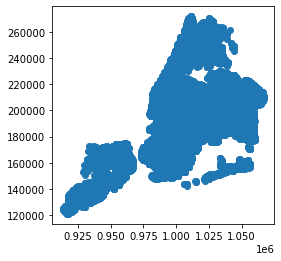

In [220]:
gdf.plot()

In [221]:
gdf.shape

(26925, 32)

In [222]:
url = 'https://data.cityofnewyork.us/api/geospatial/cpf4-rkhq?method=export&format=GeoJSON'
nta_shape = gpd.read_file(url)

print(len(nta_shape))
nta_shape.head()

195


ntacode     shape_area county_fips        ntaname     shape_leng boro_name  \
0    BK88   54005019.048         047   Borough Park  39247.2278309  Brooklyn   
1    QN51  52488277.5915         081    Murray Hill  33266.9048721    Queens   
2    QN27  19726845.5925         081  East Elmhurst  19816.7121316    Queens   
3    BK95  14522603.5915         047        Erasmus  18756.7018646  Brooklyn   
4    QN07  22887772.8087         081         Hollis  20976.3355996    Queens   

  boro_code                                           geometry  
0         3  MULTIPOLYGON (((-73.97605 40.63128, -73.97717 ...  
1         4  MULTIPOLYGON (((-73.80379 40.77561, -73.80099 ...  
2         4  MULTIPOLYGON (((-73.86110 40.76366, -73.85993 ...  
3         3  MULTIPOLYGON (((-73.94826 40.63861, -73.94923 ...  
4         4  MULTIPOLYGON (((-73.75726 40.71814, -73.75589 ...

In [223]:
nta_shape.to_crs(epsg=2263, 
                 inplace=True)

nta_shape.crs

<Projected CRS: EPSG:2263>
Name: NAD83 / New York Long Island (ftUS)
Axis Info [cartesian]:
- X[east]: Easting (US survey foot)
- Y[north]: Northing (US survey foot)
Area of Use:
- name: USA - New York - SPCS - Long Island
- bounds: (-74.26, 40.47, -71.8, 41.3)
Coordinate Operation:
- name: SPCS83 New York Long Island zone (US Survey feet)
- method: Lambert Conic Conformal (2SP)
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

<AxesSubplot:>

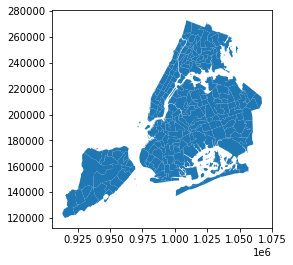

In [224]:
nta_shape.plot()

In [225]:
gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 26925 entries, 0 to 27867
Data columns (total 32 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   unique_key                      26925 non-null  int64         
 1   created_date                    26925 non-null  datetime64[ns]
 2   closed_date                     26923 non-null  object        
 3   agency                          26925 non-null  object        
 4   agency_name                     26925 non-null  object        
 5   complaint_type                  26925 non-null  object        
 6   descriptor                      26925 non-null  object        
 7   incident_zip                    26925 non-null  float64       
 8   intersection_street_1           9348 non-null   object        
 9   intersection_street_2           9348 non-null   object        
 10  address_type                    26925 non-null  object        

## 5.1 City-wide 

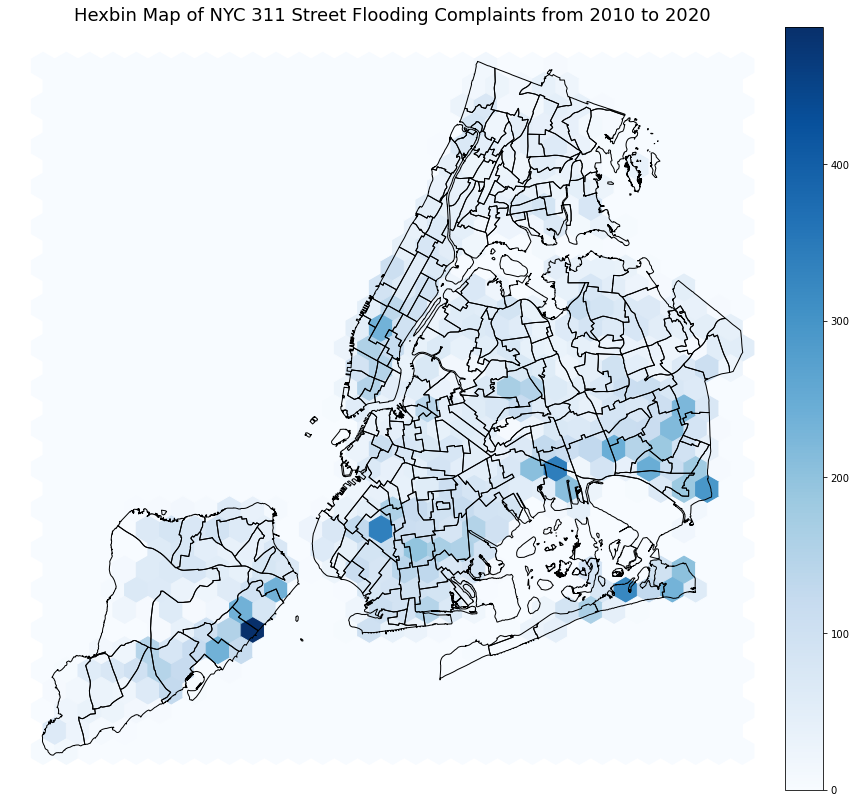

In [226]:
fig, ax = plt.subplots(figsize=(12, 12))

hb = ax.hexbin(gdf['x_coordinate_state_plane'], 
               gdf['y_coordinate_state_plane'], 
               gridsize=30, 
               cmap='Blues')

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
plt.colorbar(hb, cax=cax)

nta_shape.to_crs(2263).plot(facecolor="none", 
                            edgecolor="black", 
                            ax=ax)

ax.set_title("Hexbin Map of NYC 311 Street Flooding Complaints from 2010 to 2020", fontsize=18)
ax.set_aspect('equal', 'box')
ax.axis('off')
plt.tight_layout()

/Users/geribauer/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/Users/geribauer/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:1676: UserWarning: `shade_lowest` is now deprecated in favor of `thresh`. Setting `thresh=0.05`, but please update your code.
  warnings.warn(msg, UserWarning)


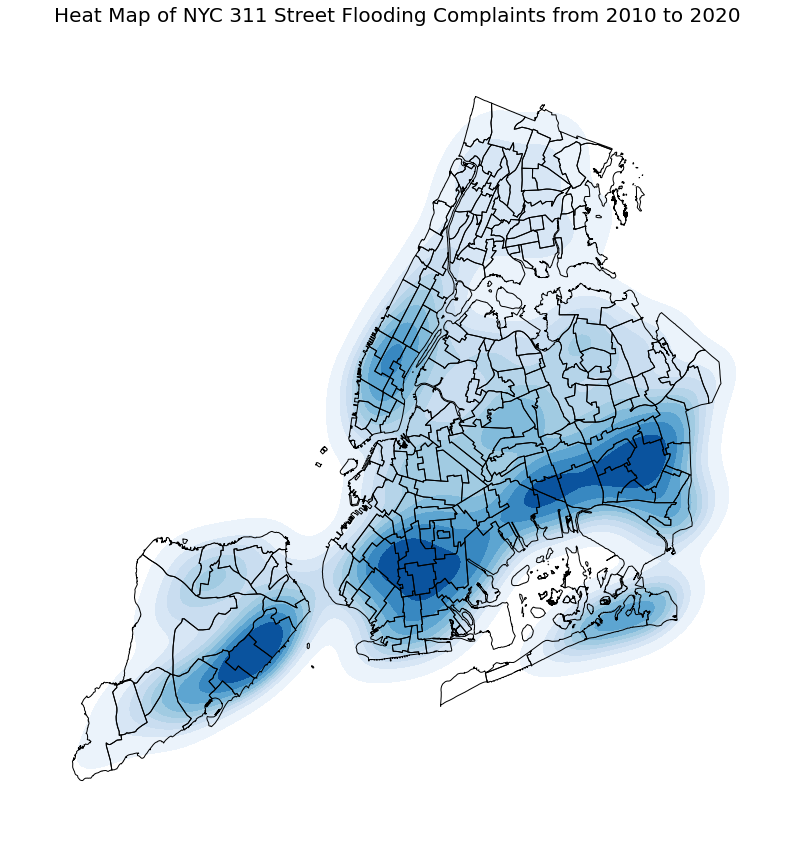

In [227]:
ax = geoplot.kdeplot(gdf.to_crs(4326),
                     shade=True, 
                     cmap='Blues',
                     projection=geoplot.crs.AlbersEqualArea(), 
                     figsize=(12, 12))

geoplot.polyplot(nta_shape.to_crs(4326), 
                 ax=ax, 
                 zorder=1)

ax.set_title('Heat Map of NYC 311 Street Flooding Complaints from 2010 to 2020', fontsize=20)
ax.set_aspect('equal', 'box')
plt.tight_layout()

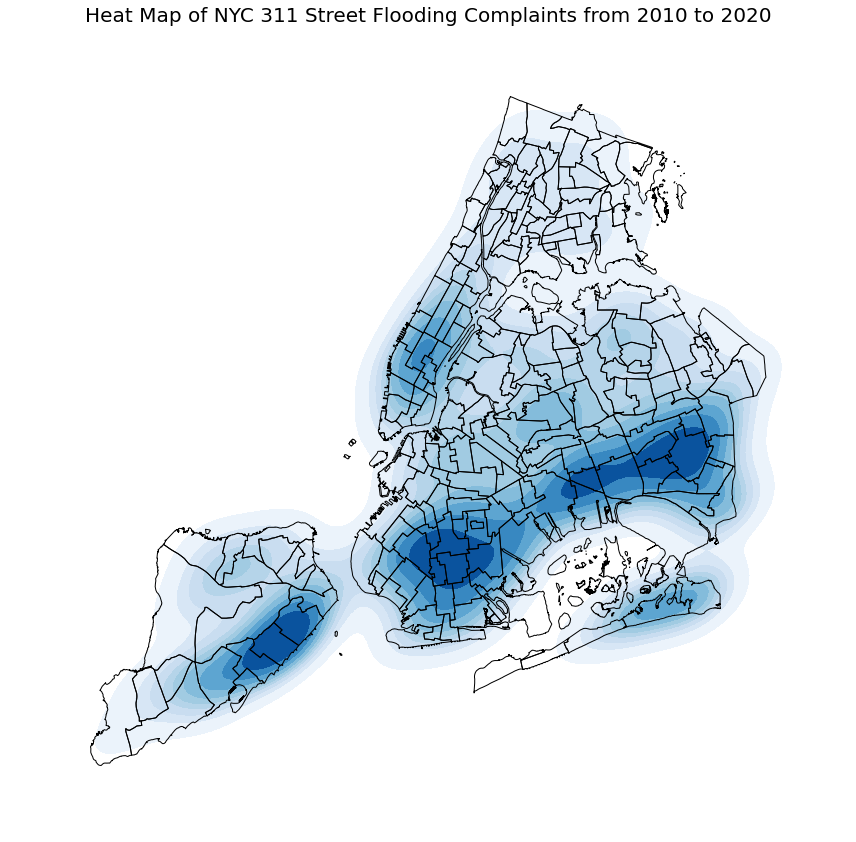

In [228]:
fig, ax = plt.subplots(figsize=(12, 12))

sns.kdeplot(data=gdf,
            x='x_coordinate_state_plane',
            y='y_coordinate_state_plane',
            fill=True,
            cmap='Blues',
            ax=ax)

nta_shape.plot(ax=ax, 
               color='None', 
               edgecolor='black', 
               zorder=1)

ax.set_title('Heat Map of NYC 311 Street Flooding Complaints from 2010 to 2020', fontsize=20)
ax.set_aspect('equal', 'box')
ax.axis('off')
plt.tight_layout()
plt.savefig('figures/cover-photo.png')

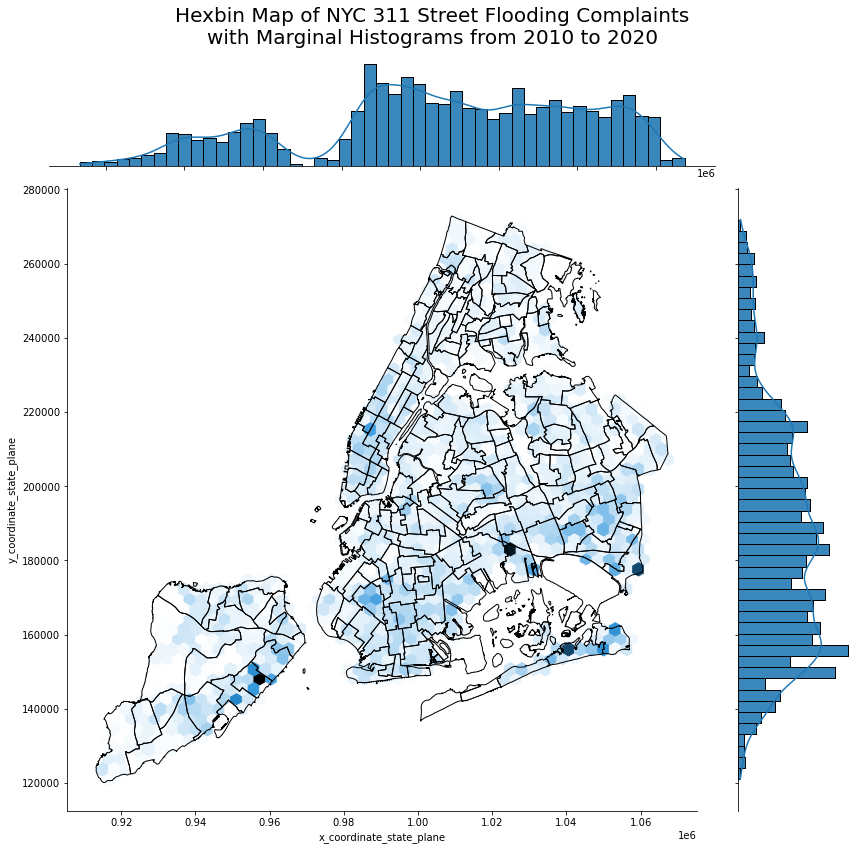

In [229]:
g = sns.jointplot(x='x_coordinate_state_plane',
                  y='y_coordinate_state_plane', 
                  data=gdf,
                  kind="hex", 
                  height=12) 

g.plot_marginals(sns.histplot, 
                 kde=True)


nta_shape.to_crs(epsg=2263).plot(ax=g.ax_joint, 
                                 zorder=1, 
                                 color='none', 
                                 edgecolor='black')


g.fig.suptitle('Hexbin Map of NYC 311 Street Flooding Complaints\nwith Marginal ' + \
               'Histograms from 2010 to 2020\n', 
               fontsize=20)
g.fig.subplots_adjust(top=0.92)

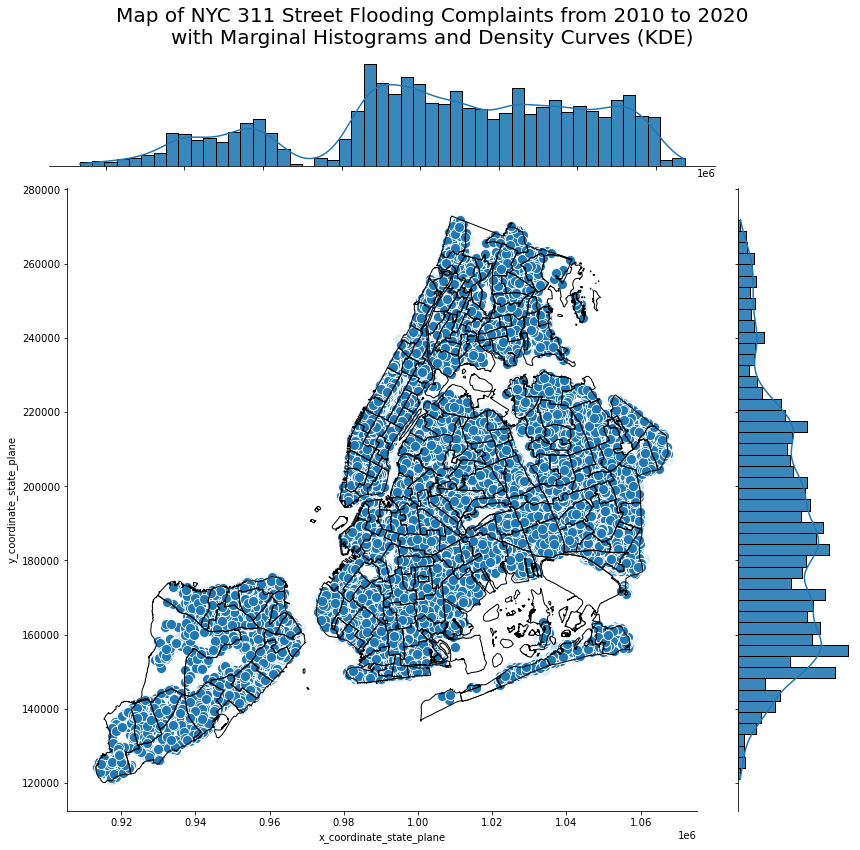

In [230]:
g = sns.jointplot(x='x_coordinate_state_plane',
                  y='y_coordinate_state_plane', 
                  data=gdf,
                  kind="hex", 
                  color='#1f77b4',
                  height=12) 

g.plot_joint(sns.scatterplot, 
             s=100)

g.plot_marginals(sns.histplot, 
                 kde=True)

nta_shape.to_crs(epsg=2263).plot(ax=g.ax_joint, 
                                 zorder=1, 
                                 color='none', 
                                 edgecolor='black')

g.fig.suptitle('Map of NYC 311 Street Flooding Complaints from 2010 to 2020\n' + \
               'with Marginal Histograms and Density Curves (KDE)', 
               fontsize=20)
g.fig.subplots_adjust(top=0.92)

In [231]:
g = sns.JointGrid(x='x_coordinate_state_plane',
                  y='y_coordinate_state_plane', 
                  data=gdf,
                  height=12) 

g.plot(sns.scatterplot, 
       sns.boxplot)



nta_shape.to_crs(epsg=2263).plot(ax=g.ax_joint, 
                                 zorder=1, 
                                 color='none', 
                                 edgecolor='black')

g.fig.suptitle("Map of NYC 311 Street Flooding Complaints from 2010 to 2020 with Boxplots", 
               fontsize=20)
g.fig.subplots_adjust(top=0.94)
plt.savefig('figures/suptitle.png')

In [232]:
gdf.iloc[:, -4:]

cross_street_2           bbl  year                        geometry
0      BEACH CHANNEL DRIVE           NaN  2015  POINT (1033547.000 152391.000)
1           EAST 88 STREET           NaN  2013  POINT (1010685.000 171510.000)
2           EAST 88 STREET           NaN  2013  POINT (1010685.000 171510.000)
3           EAST 88 STREET           NaN  2013  POINT (1010685.000 171510.000)
4           EAST 88 STREET           NaN  2013  POINT (1010685.000 171510.000)
...                    ...           ...   ...                             ...
27863            E LAKE DR 3050240001.00  2015   POINT (994559.000 180008.000)
27864              E 28 ST           NaN  2012   POINT (990831.000 208889.000)
27865           WILLIS AVE           NaN  2012  POINT (1005084.000 233135.000)
27866      GUY BREWER BLVD           NaN  2015  POINT (1042459.000 192547.000)
27867            HEALY AVE 4157170078.00  2015  POINT (1051159.000 159772.000)

[26925 rows x 4 columns]

In [233]:
len(gdf)

26925

In [234]:
gdf[['geometry']].notnull().sum()

geometry    26925
dtype: int64

In [235]:
gdf[['geometry']].isnull().sum()

geometry    0
dtype: int64

In [236]:
flooding_complaints_with_nta = gpd.sjoin(gdf, 
                                         nta_shape, 
                                         how="inner", 
                                         op='within')

In [237]:
len(flooding_complaints_with_nta)

26923

In [238]:
print('Our new dataframe contains ' + \
      f"{len(flooding_complaints_with_nta):,}" + ' rows.\n')

print("We've dropped " + \
      f"{round((1 - len(flooding_complaints_with_nta)/len(gdf)) * 100, 2):,}" + \
      ' percent of our data in our spatial join process.')

Our new dataframe contains 26,923 rows.

We've dropped 0.01 percent of our data in our spatial join process.


In [239]:
flooding_complaints_with_nta.head()

unique_key        created_date              closed_date agency  \
0      31862075 2015-10-28 17:44:00  2015-10-29T11:30:00.000    DEP   
352    48315004 2020-12-03 11:59:00  2020-12-04T10:45:00.000    DEP   
379    48257821 2020-11-26 17:09:00  2020-12-08T15:25:00.000    DEP   
424    48351959 2020-12-07 09:26:00  2020-12-15T17:30:00.000    DEP   
698    47194494 2020-08-10 14:49:00  2020-08-11T11:50:00.000    DEP   

                                agency_name complaint_type  \
0    Department of Environmental Protection          Sewer   
352  Department of Environmental Protection          Sewer   
379  Department of Environmental Protection          Sewer   
424  Department of Environmental Protection          Sewer   
698  Department of Environmental Protection          Sewer   

               descriptor  incident_zip intersection_street_1  \
0    Street Flooding (SJ)      11694.00                   NaN   
352  Street Flooding (SJ)      11694.00                   NaN   
379  Street Flooding (SJ)      11694.00                   NaN   
424  Street Flooding (SJ)      11694.00                   NaN   
698  Street Flooding (SJ)      11694.00                   NaN   

    intersection_street_2  ...  year                        geometry  \
0                     NaN  ...  2015  POINT (1033547.000 152391.000)   
352                   NaN  ...  2020  POINT (1021913.000 146937.000)   
379                   NaN  ...  2020  POINT (1026335.000 149464.000)   
424                   NaN  ...  2020  POINT (1029969.000 151595.000)   
698                   NaN  ...  2020  POINT (1026572.000 148945.000)   

    index_right ntacode     shape_area county_fips  \
0           182    QN10  100209724.039         081   
352         182    QN10  100209724.039         081   
379         182    QN10  100209724.039         081   
424         182    QN10  100209724.039         081   
698         182    QN10  100209724.039         081   

                                               ntaname     shape_leng  \
0    Breezy Point-Belle Harbor-Rockaway Park-Broad ...  119016.703209   
352  Breezy Point-Belle Harbor-Rockaway Park-Broad ...  119016.703209   
379  Breezy Point-Belle Harbor-Rockaway Park-Broad ...  119016.703209   
424  Breezy Point-Belle Harbor-Rockaway Park-Broad ...  119016.703209   
698  Breezy Point-Belle Harbor-Rockaway Park-Broad ...  119016.703209   

     boro_name boro_code  
0       Queens         4  
352     Queens         4  
379     Queens         4  
424     Queens         4  
698     Queens         4  

[5 rows x 40 columns]

In [240]:
flooding_complaints_with_nta.shape

(26923, 40)

In [241]:
flooding_complaints_with_nta['boro_name'].value_counts(dropna=False)

Queens           10626
Brooklyn          6934
Staten Island     4921
Manhattan         2549
Bronx             1893
Name: boro_name, dtype: int64

In [242]:
flooding_complaints_with_nta['ntaname'].value_counts(dropna=False)

New Dorp-Midland Beach             763
Hammels-Arverne-Edgemere           696
Lindenwood-Howard Beach            606
St. Albans                         577
Far Rockaway-Bayswater             540
                                  ... 
Starrett City                        9
Fordham South                        8
Parkchester                          6
park-cemetery-etc-Staten Island      5
Airport                              3
Name: ntaname, Length: 194, dtype: int64

<AxesSubplot:>

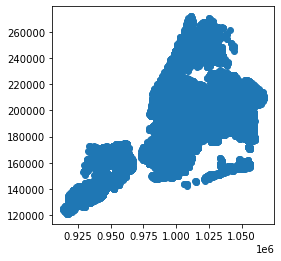

In [243]:
flooding_complaints_with_nta.plot()

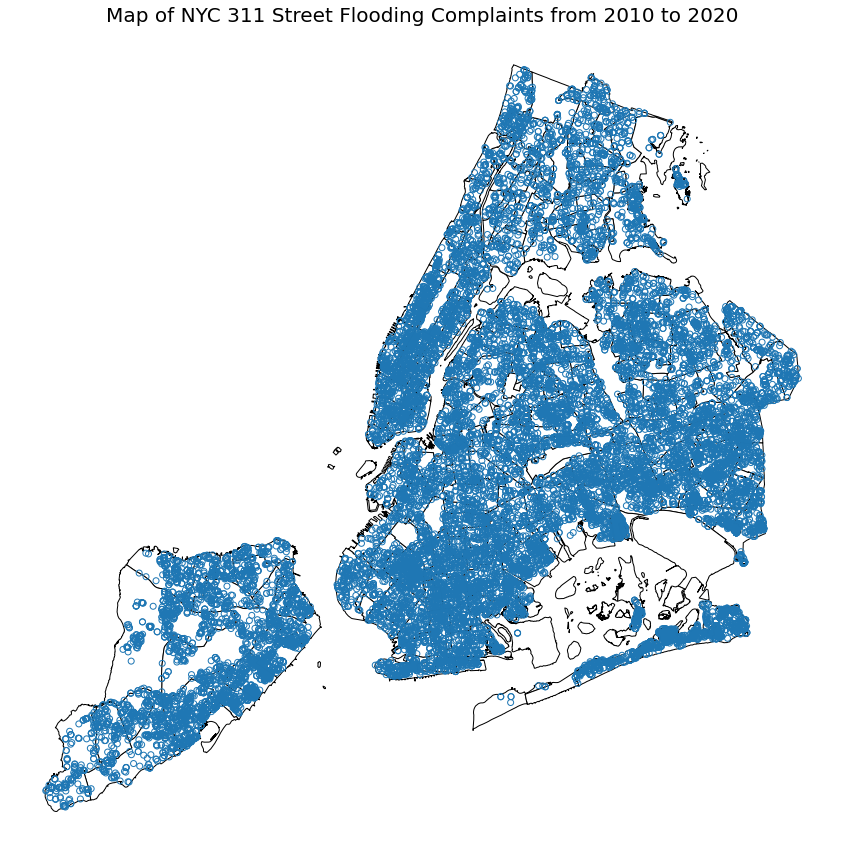

In [244]:
fig, ax = plt.subplots(figsize=(12,12))


nta_shape.plot(ax=ax, 
               color='white', 
               edgecolor='black', 
               zorder=0)

flooding_complaints_with_nta.plot(ax=ax, 
                                  color='None',
                                  edgecolor='#1f77b4')
ax.set_aspect('equal', 'box')
ax.set_title("Map of NYC 311 Street Flooding Complaints from 2010 to 2020", fontsize=20)
plt.axis('off')
plt.tight_layout()

In [245]:
flooding_complaints_with_nta = flooding_complaints_with_nta.groupby(by='ntaname')['unique_key'].count().reset_index()
flooding_complaints_with_nta.rename(columns={"unique_key": "count"}, 
                                    inplace=True)

flooding_complaints_with_nta.sort_values(by='count', 
                                         ascending=False).head()

ntaname  count
116    New Dorp-Midland Beach    763
80   Hammels-Arverne-Edgemere    696
97    Lindenwood-Howard Beach    606
157                St. Albans    577
61     Far Rockaway-Bayswater    540

In [246]:
flooding_complaints_with_nta['count'].sum()

26923

In [247]:
flooding_complaints_with_nta = nta_shape.merge(flooding_complaints_with_nta, 
                                               left_on='ntaname', 
                                               right_on='ntaname')

In [248]:
flooding_complaints_with_nta.head()

ntacode     shape_area county_fips        ntaname     shape_leng boro_name  \
0    BK88   54005019.048         047   Borough Park  39247.2278309  Brooklyn   
1    QN51  52488277.5915         081    Murray Hill  33266.9048721    Queens   
2    QN27  19726845.5925         081  East Elmhurst  19816.7121316    Queens   
3    BK95  14522603.5915         047        Erasmus  18756.7018646  Brooklyn   
4    QN07  22887772.8087         081         Hollis  20976.3355996    Queens   

  boro_code                                           geometry  count  
0         3  MULTIPOLYGON (((990897.900 169268.121, 990588....    537  
1         4  MULTIPOLYGON (((1038593.459 221913.355, 103936...    168  
2         4  MULTIPOLYGON (((1022728.275 217530.808, 102305...     43  
3         3  MULTIPOLYGON (((998608.334 171942.436, 998339....     80  
4         4  MULTIPOLYGON (((1051539.660 201007.013, 105192...    127

In [249]:
flooding_complaints_with_nta['count'].sum()

26923

In [250]:
flooding_complaints_with_nta[['ntaname', 'count']].sort_values(by='count', 
                                                               ascending=False).head()

ntaname  count
94     New Dorp-Midland Beach    763
130  Hammels-Arverne-Edgemere    696
160   Lindenwood-Howard Beach    606
9                  St. Albans    577
133    Far Rockaway-Bayswater    540

In [251]:
flooding_complaints_with_nta[['ntaname', 'count']].sort_values(by='count', 
                                                               ascending=True).head()

ntaname  count
177                          Airport      3
193  park-cemetery-etc-Staten Island      5
34                       Parkchester      6
86                     Fordham South      8
12                     Starrett City      9

In [252]:
flooding_complaints_with_nta.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 194 entries, 0 to 193
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   ntacode      194 non-null    object  
 1   shape_area   194 non-null    object  
 2   county_fips  194 non-null    object  
 3   ntaname      194 non-null    object  
 4   shape_leng   194 non-null    object  
 5   boro_name    194 non-null    object  
 6   boro_code    194 non-null    object  
 7   geometry     194 non-null    geometry
 8   count        194 non-null    int64   
dtypes: geometry(1), int64(1), object(7)
memory usage: 15.2+ KB


In [253]:
flooding_complaints_with_nta['shape_area'] = flooding_complaints_with_nta['shape_area'].astype(float)
flooding_complaints_with_nta['shape_leng'] = flooding_complaints_with_nta['shape_leng'].astype(float)
                                                                          
flooding_complaints_with_nta.info()                                                                          

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 194 entries, 0 to 193
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   ntacode      194 non-null    object  
 1   shape_area   194 non-null    float64 
 2   county_fips  194 non-null    object  
 3   ntaname      194 non-null    object  
 4   shape_leng   194 non-null    float64 
 5   boro_name    194 non-null    object  
 6   boro_code    194 non-null    object  
 7   geometry     194 non-null    geometry
 8   count        194 non-null    int64   
dtypes: float64(2), geometry(1), int64(1), object(5)
memory usage: 15.2+ KB


In [254]:
flooding_complaints_with_nta['count_sq_mi'] = (flooding_complaints_with_nta['count'] / 
                                              ((flooding_complaints_with_nta['shape_area'] / 27878400)))

flooding_complaints_with_nta.head() 

ntacode  shape_area county_fips        ntaname  shape_leng boro_name  \
0    BK88 54005019.05         047   Borough Park    39247.23  Brooklyn   
1    QN51 52488277.59         081    Murray Hill    33266.90    Queens   
2    QN27 19726845.59         081  East Elmhurst    19816.71    Queens   
3    BK95 14522603.59         047        Erasmus    18756.70  Brooklyn   
4    QN07 22887772.81         081         Hollis    20976.34    Queens   

  boro_code                                           geometry  count  \
0         3  MULTIPOLYGON (((990897.900 169268.121, 990588....    537   
1         4  MULTIPOLYGON (((1038593.459 221913.355, 103936...    168   
2         4  MULTIPOLYGON (((1022728.275 217530.808, 102305...     43   
3         3  MULTIPOLYGON (((998608.334 171942.436, 998339....     80   
4         4  MULTIPOLYGON (((1051539.660 201007.013, 105192...    127   

   count_sq_mi  
0       277.21  
1        89.23  
2        60.77  
3       153.57  
4       154.69

In [255]:
flooding_complaints_with_nta[['count', 'count_sq_mi']].describe()

count  count_sq_mi
count 194.00       194.00
mean  138.78        98.54
std   135.41        62.08
min     3.00         0.37
25%    53.25        58.51
50%    94.00        82.97
75%   168.00       129.76
max   763.00       383.75

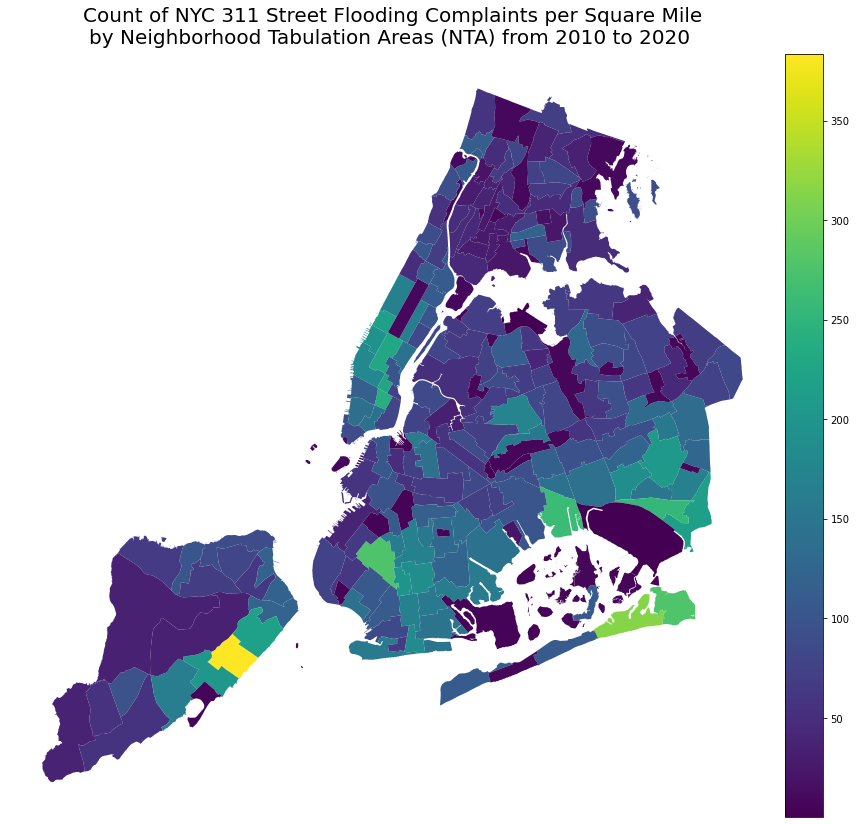

In [256]:
fig, ax = plt.subplots(figsize=(12,12))

comma_fmt = FuncFormatter(lambda x, p: format(int(x), ','))
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)

flooding_complaints_with_nta.plot(column='count_sq_mi', 
                                  cmap='viridis',
                                  ax=ax, 
                                  legend=True,
                                  cax=cax,
                                  legend_kwds={'format':comma_fmt})

ax.set_title('Count of NYC 311 Street Flooding Complaints per Square Mile\nby Neighborhood Tabulation Areas (NTA) from 2010 to 2020 ', 
             fontsize=20, 
             pad=10)

ax.set_aspect('equal', 'box')
ax.axis('off')
plt.tight_layout()

In [257]:
fig, ax = plt.subplots(figsize=(12,12))

flooding_complaints_with_nta.plot(column='count_sq_mi', 
                                  cmap='viridis',
                                  ax=ax, 
                                  legend=True, 
                                  scheme='fisher_jenks',
                                  k=7,
                                  legend_kwds={'loc': "upper left", 
                                              'fmt': "{:,.0f}",
                                              'fontsize': "20"})
leg = ax.get_legend()

hp = leg._legend_box.get_children()[1]
for vp in hp.get_children():
    for row in vp.get_children():
        row.set_width(150) 
        row.mode= "expand"
        row.align="right" 

ax.set_title('Count of NYC 311 Street Flooding Complaints per Square Mile\nby Neighborhood Tabulation Areas (NTA) from 2010 to 2020', 
             fontsize=20, 
             pad=10)

ax.set_aspect('equal', 'box')
ax.axis('off')
plt.tight_layout()

In [258]:
flooding_complaints_with_nta.to_csv('data-output/count-complaints-by-nta.csv', index=False)

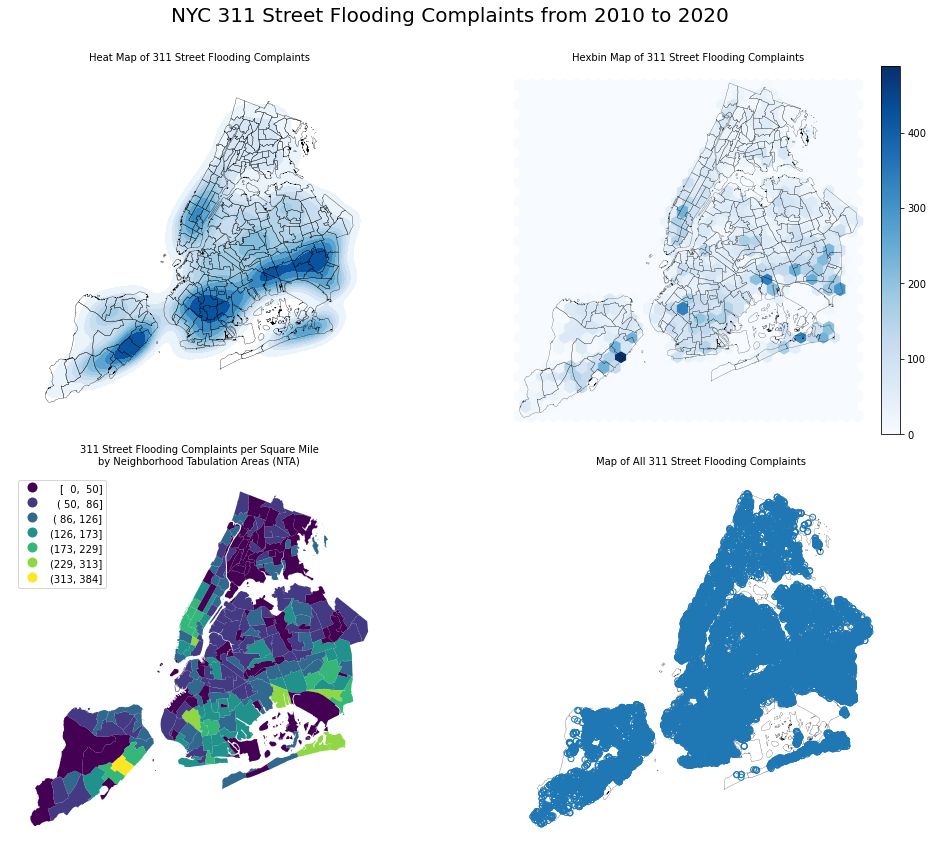

In [259]:
fig, axs = plt.subplots(2, 2, sharey=False, figsize=(15, 12))


# First Plot
sns.kdeplot(data=gdf,
            x='x_coordinate_state_plane',
            y='y_coordinate_state_plane',
            fill=True,
            cmap='Blues',
            ax=axs[0,0])

nta_shape.plot(ax=axs[0,0], 
               color='None', 
               edgecolor='black', 
               zorder=1,
               linewidth=.3)

axs[0,0].set_title("Heat Map of 311 Street Flooding Complaints", 
             fontsize=10)
axs[0,0].set_aspect('equal', 'box')
axs[0,0].axis('off')


# Second Plot
hb = axs[0,1].hexbin(flooding_311['x_coordinate_state_plane'], 
                               flooding_311['y_coordinate_state_plane'], 
                               gridsize=30, 
                               cmap='Blues')

divider = make_axes_locatable(axs[0,1])
cax = divider.append_axes("right", size="5%", pad=0.1)
plt.colorbar(hb, cax=cax)

nta_shape.to_crs(2263).plot(facecolor="none", 
                            edgecolor="black", 
                            linewidth=.2,
                            ax=axs[0,1])

axs[0,1].set_title("Hexbin Map of 311 Street Flooding Complaints", 
             fontsize=10)
axs[0,1].set_aspect('equal', 'box')
axs[0,1].axis('off')


# Third Plot
flooding_complaints_with_nta.plot(column='count_sq_mi', 
                                  cmap='viridis',
                                  ax=axs[1,0], 
                                  legend=True, 
                                  scheme='fisher_jenks',
                                  k=7,
                                  legend_kwds={'loc': "upper left", 
                                              'fmt': "{:,.0f}",
                                              'fontsize': "10"})
leg = axs[1,0].get_legend()

hp = leg._legend_box.get_children()[1]
for vp in hp.get_children():
    for row in vp.get_children():
        row.set_width(80)  # need to adapt this manually
        row.mode= "expand"
        row.align="right" 

axs[1,0].set_title('311 Street Flooding Complaints per Square Mile\nby Neighborhood Tabulation Areas (NTA)', 
             fontsize=10, 
             pad=10)

axs[1,0].set_aspect('equal', 'box')
axs[1,0].axis('off')


# Fourth Plot
nta_shape.plot(ax=axs[1,1], 
               color='white', 
               edgecolor='black', 
               linewidth=.2,
               zorder=0)

gdf.plot(ax=axs[1,1], 
         color='None', 
         edgecolor='#1f77b4')

axs[1,1].set_title("Map of All 311 Street Flooding Complaints", 
                   fontsize=10, 
                   pad=10)
axs[1,1].set_aspect('equal', 'box')
axs[1,1].axis('off')

# Figure Details
fig.suptitle('NYC 311 Street Flooding Complaints from 2010 to 2020\n', fontsize=20) 

plt.tight_layout()
plt.savefig('figures/sample.png')

In [260]:
year_nta = gpd.sjoin(gdf, 
                     nta_shape, 
                     how="inner", 
                     op='within')

In [261]:
len(gdf)

26925

In [262]:
len(year_nta)

26923

In [263]:
year_nta.head()

unique_key        created_date              closed_date agency  \
0      31862075 2015-10-28 17:44:00  2015-10-29T11:30:00.000    DEP   
352    48315004 2020-12-03 11:59:00  2020-12-04T10:45:00.000    DEP   
379    48257821 2020-11-26 17:09:00  2020-12-08T15:25:00.000    DEP   
424    48351959 2020-12-07 09:26:00  2020-12-15T17:30:00.000    DEP   
698    47194494 2020-08-10 14:49:00  2020-08-11T11:50:00.000    DEP   

                                agency_name complaint_type  \
0    Department of Environmental Protection          Sewer   
352  Department of Environmental Protection          Sewer   
379  Department of Environmental Protection          Sewer   
424  Department of Environmental Protection          Sewer   
698  Department of Environmental Protection          Sewer   

               descriptor  incident_zip intersection_street_1  \
0    Street Flooding (SJ)      11694.00                   NaN   
352  Street Flooding (SJ)      11694.00                   NaN   
379  Street Flooding (SJ)      11694.00                   NaN   
424  Street Flooding (SJ)      11694.00                   NaN   
698  Street Flooding (SJ)      11694.00                   NaN   

    intersection_street_2  ...  year                        geometry  \
0                     NaN  ...  2015  POINT (1033547.000 152391.000)   
352                   NaN  ...  2020  POINT (1021913.000 146937.000)   
379                   NaN  ...  2020  POINT (1026335.000 149464.000)   
424                   NaN  ...  2020  POINT (1029969.000 151595.000)   
698                   NaN  ...  2020  POINT (1026572.000 148945.000)   

    index_right ntacode     shape_area county_fips  \
0           182    QN10  100209724.039         081   
352         182    QN10  100209724.039         081   
379         182    QN10  100209724.039         081   
424         182    QN10  100209724.039         081   
698         182    QN10  100209724.039         081   

                                               ntaname     shape_leng  \
0    Breezy Point-Belle Harbor-Rockaway Park-Broad ...  119016.703209   
352  Breezy Point-Belle Harbor-Rockaway Park-Broad ...  119016.703209   
379  Breezy Point-Belle Harbor-Rockaway Park-Broad ...  119016.703209   
424  Breezy Point-Belle Harbor-Rockaway Park-Broad ...  119016.703209   
698  Breezy Point-Belle Harbor-Rockaway Park-Broad ...  119016.703209   

     boro_name boro_code  
0       Queens         4  
352     Queens         4  
379     Queens         4  
424     Queens         4  
698     Queens         4  

[5 rows x 40 columns]

In [264]:
year_nta = year_nta.groupby(by=['year', 
                                'ntaname'])['unique_key'].count().reset_index()

year_nta.rename(columns={"unique_key": "count"}, 
                inplace=True)

year_nta = nta_shape.merge(year_nta, 
                           left_on='ntaname', 
                           right_on='ntaname')

year_nta['count_sq_mi'] = (year_nta['count'] / (year_nta['shape_area'].astype(float) / 27878400))

year_nta.head()

ntacode    shape_area county_fips       ntaname     shape_leng boro_name  \
0    BK88  54005019.048         047  Borough Park  39247.2278309  Brooklyn   
1    BK88  54005019.048         047  Borough Park  39247.2278309  Brooklyn   
2    BK88  54005019.048         047  Borough Park  39247.2278309  Brooklyn   
3    BK88  54005019.048         047  Borough Park  39247.2278309  Brooklyn   
4    BK88  54005019.048         047  Borough Park  39247.2278309  Brooklyn   

  boro_code                                           geometry  year  count  \
0         3  MULTIPOLYGON (((990897.900 169268.121, 990588....  2010     45   
1         3  MULTIPOLYGON (((990897.900 169268.121, 990588....  2011     44   
2         3  MULTIPOLYGON (((990897.900 169268.121, 990588....  2012     34   
3         3  MULTIPOLYGON (((990897.900 169268.121, 990588....  2013     18   
4         3  MULTIPOLYGON (((990897.900 169268.121, 990588....  2014     48   

   count_sq_mi  
0        23.23  
1        22.71  
2        17.55  
3         9.29  
4        24.78

In [265]:
years = list(year_nta.year.unique())

In [266]:
print(type(years))
print(years)

<class 'list'>
[2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020]


In [267]:
print('Indexing for year 2012 (2nd position starting at 0) in our list. Here, I index for', years[2])

year_nta[year_nta['year'] == years[2]].plot(column='count_sq_mi', 
                                            cmap='viridis',
                                            legend=True)
plt.title(years[2])

Indexing for year 2012 (2nd position starting at 0) in our list. Here, I index for 2012


Text(0.5, 1.0, '2012')

In [268]:
year_nta.to_csv('data-output/count-complaints-by-year-nta.csv', index=False)

In [269]:
indx = 0

fig, axes = plt.subplots(3, 4, figsize=(12, 12))

for ax in axes.flat:
    
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.1)
    
    year_nta[year_nta['year'] == years[indx]].plot(column='count_sq_mi', 
                                                   cmap='viridis',
                                                   legend=True,
                                                   ax=ax, 
                                                   cax=cax)

    ax.set_title(str(years[indx]), fontsize=12)
    ax.set_aspect('equal', 'box')
    ax.axis('off')
    plt.tight_layout()
    
    indx += 1
    if indx == 11:
        break

    axes[2,3].set_axis_off()
    
# Figure Details
fig.suptitle('Count of NYC 311 Street Flooding Complaints per Square Mile\nby Neighborhood Tabulation Areas (NTA) and Year', fontsize=17) 
plt.savefig('figures/example.png')    

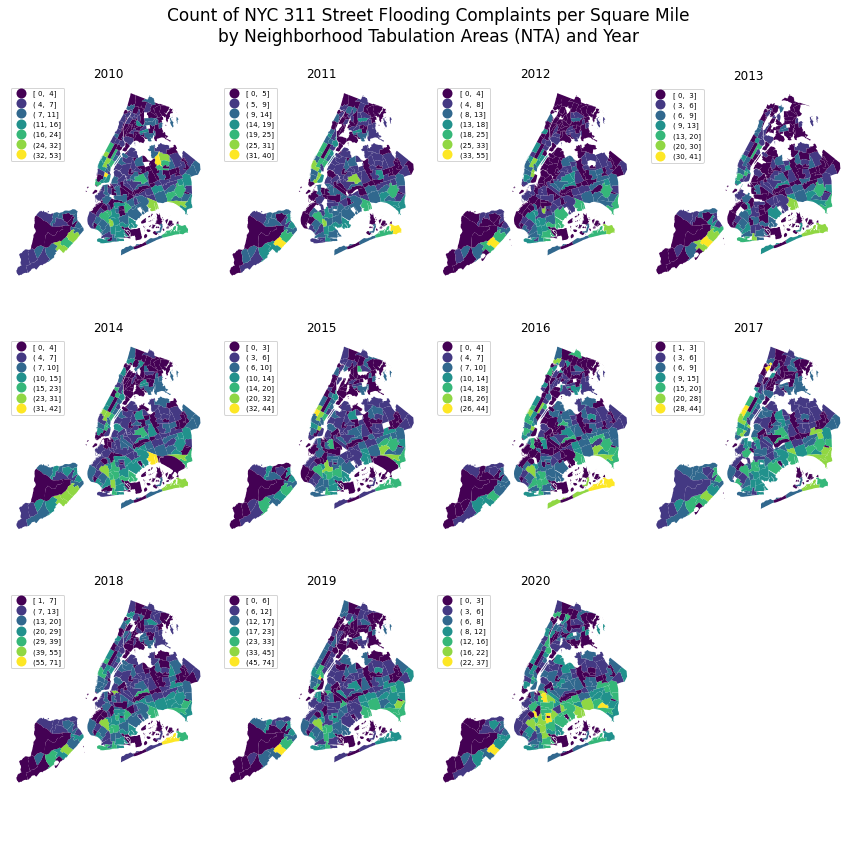

In [270]:
indx = 0

fig, axes = plt.subplots(3, 4, figsize=(12, 12))

for ax in axes.flat:
    year_nta[year_nta['year'] == years[indx]].plot(column='count_sq_mi', 
                                              cmap='viridis',
                                              legend=True, 
                                              figsize=(6,6),
                                              scheme='fisher_jenks',
                                              k=7,
                                              legend_kwds={'loc': "upper left", 
                                                           'fmt': "{:,.0f}",
                                                           'fontsize': "7"},
                                              ax=ax)

    
    ax.set_title(str(years[indx]), fontsize=12)
    ax.set_aspect('equal', 'box')
    ax.axis('off')
    plt.tight_layout()
    
    indx += 1
    if indx == 11:
        break

    axes[2,3].set_axis_off()   

# Figure Details
fig.suptitle('Count of NYC 311 Street Flooding Complaints per Square Mile\nby Neighborhood Tabulation Areas (NTA) and Year', fontsize=17)
fig.subplots_adjust(top=0.95)
plt.savefig('figures/example.png', dpi=150) 

In [271]:
indx = 0

fig, axes = plt.subplots(3, 4, figsize=(12, 12))

for ax in axes.flat:
    
    df = flooding_311[flooding_311['year'] == years[indx]]

    hb = ax.hexbin(df.x_coordinate_state_plane, 
                   df.y_coordinate_state_plane, 
                   gridsize=30, 
                   cmap='Blues')

    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.1)
    plt.colorbar(hb, cax=cax)

    nta_shape.to_crs(2263).plot(facecolor="none", 
                                edgecolor="black", 
                                ax=ax,
                                zorder=1,
                                linewidth=.1)

    
    ax.set_title(str(years[indx]), fontsize=12)
    ax.set_aspect('equal', 'box')
    ax.axis('off')
    plt.tight_layout()
    
    indx += 1
    if indx == 11:
        break

    axes[2,3].set_axis_off()   
    
# Figure Details
fig.suptitle('Hexbin Map of NYC 311 Street Flooding Complaints by Year', fontsize=17) 
# plt.savefig('figures/example.png')     

Text(0.5, 0.98, 'Hexbin Map of NYC 311 Street Flooding Complaints by Year')

## 5.2 By Borough

In [272]:
flooding_311.borough.value_counts()

QUEENS           11032
BROOKLYN          7109
STATEN ISLAND     5015
MANHATTAN         2616
BRONX             2076
Unspecified         20
Name: borough, dtype: int64

In [273]:
nta_shape.boro_name.value_counts()

Queens           58
Brooklyn         51
Bronx            38
Manhattan        29
Staten Island    19
Name: boro_name, dtype: int64

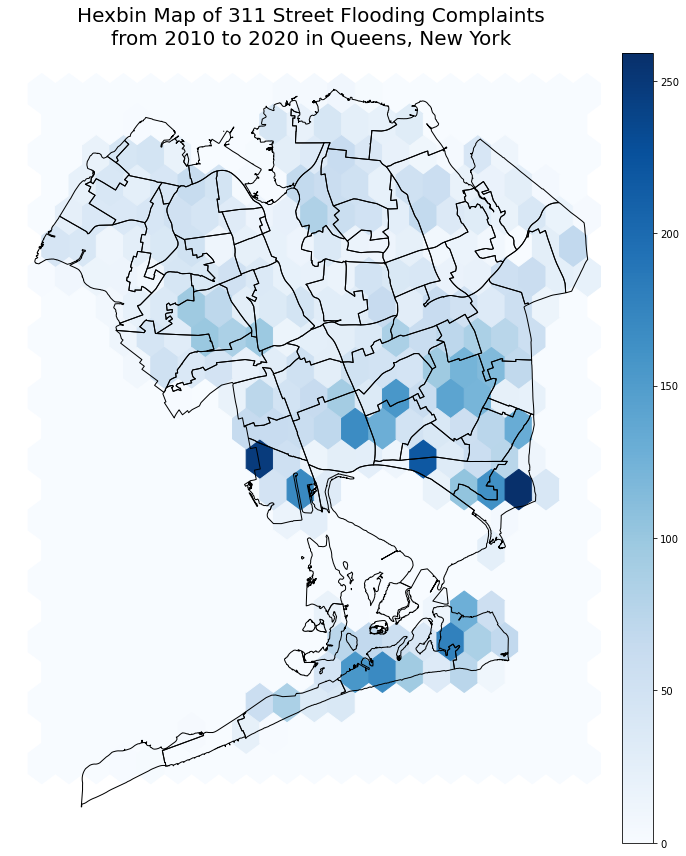

In [274]:
fig, ax = plt.subplots(figsize=(12, 12))

hb = ax.hexbin(flooding_311[flooding_311.borough == 'QUEENS']['x_coordinate_state_plane'], 
               flooding_311[flooding_311.borough == 'QUEENS']['y_coordinate_state_plane'], 
               gridsize=20, 
               cmap='Blues')

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
plt.colorbar(hb, cax=cax)

nta_shape[nta_shape.boro_name == 'Queens'].to_crs(2263).plot(facecolor="none", 
                                                             edgecolor="black", 
                                                             ax=ax)

ax.set_aspect('equal', 'box')
ax.axis('off')
ax.set_title('Hexbin Map of 311 Street Flooding Complaints\nfrom 2010 to 2020 in Queens, New York', 
             fontsize=20, 
             pad=10)
plt.tight_layout()

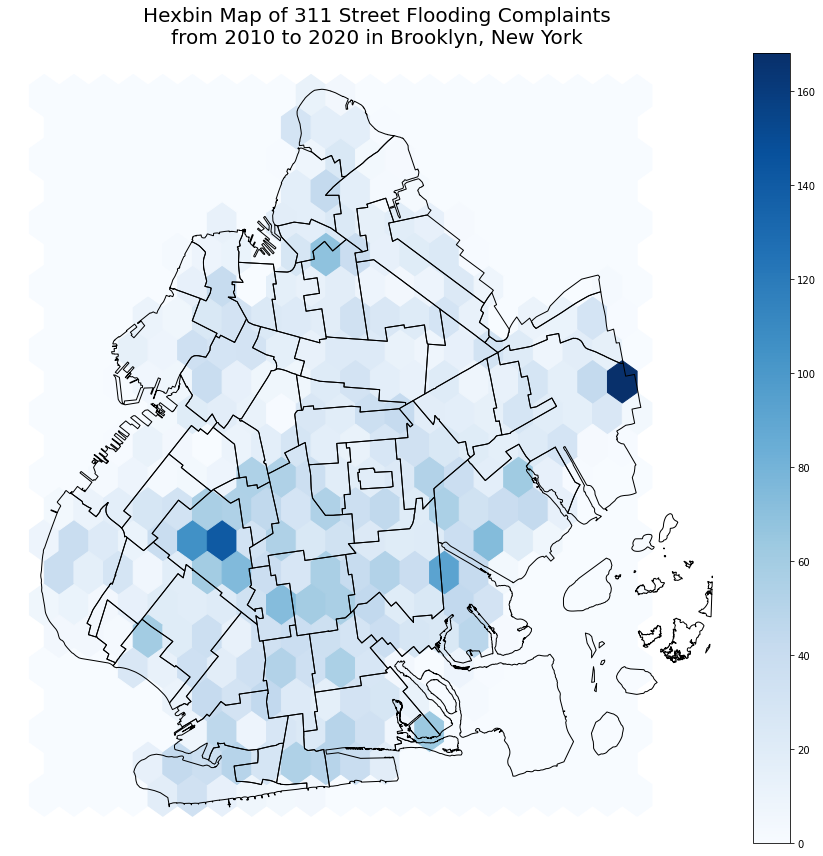

In [275]:
fig, ax = plt.subplots(figsize=(12, 12))

hb = ax.hexbin(flooding_311[flooding_311.borough == 'BROOKLYN']['x_coordinate_state_plane'], 
               flooding_311[flooding_311.borough == 'BROOKLYN']['y_coordinate_state_plane'], 
               gridsize=20, 
               cmap='Blues')

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
plt.colorbar(hb, cax=cax)

nta_shape[nta_shape.boro_name == 'Brooklyn'].to_crs(2263).plot(facecolor="none", 
                                                             edgecolor="black", 
                                                             ax=ax)

ax.set_aspect('equal', 'box')
ax.axis('off')
ax.set_title('Hexbin Map of 311 Street Flooding Complaints\nfrom 2010 to 2020 in Brooklyn, New York', 
             fontsize=20, 
             pad=10)
plt.tight_layout()

In [276]:
fig, ax = plt.subplots(figsize=(12, 12))

hb = ax.hexbin(flooding_311[flooding_311.borough == 'BRONX']['x_coordinate_state_plane'], 
               flooding_311[flooding_311.borough == 'BRONX']['y_coordinate_state_plane'], 
               gridsize=20, 
               cmap='Blues')

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
plt.colorbar(hb, cax=cax)

nta_shape[nta_shape.boro_name == 'Bronx'].to_crs(2263).plot(facecolor="none", 
                                                             edgecolor="black", 
                                                             ax=ax)

ax.set_aspect('equal', 'box')
ax.axis('off')
ax.set_title('Hexbin Map of 311 Street Flooding Complaints\nfrom 2010 to 2020 in The Bronx, New York', 
             fontsize=20, 
             pad=10)
plt.tight_layout()

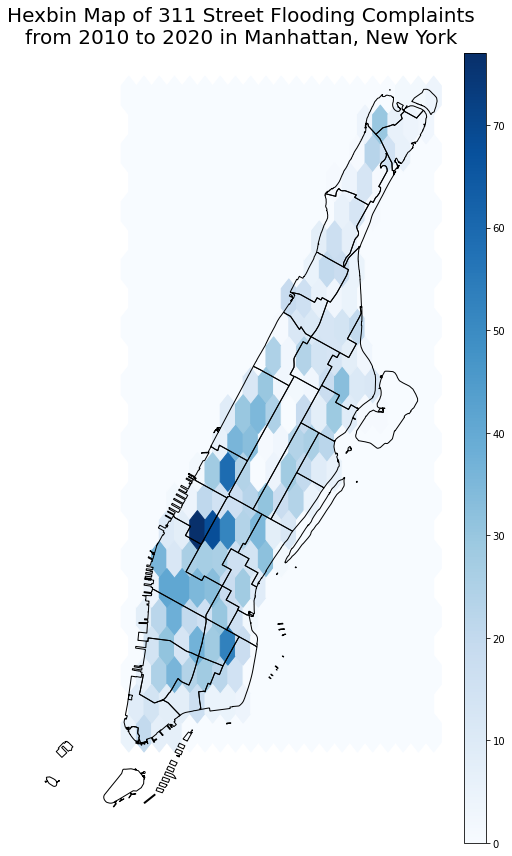

In [277]:
fig, ax = plt.subplots(figsize=(12, 12))

hb = ax.hexbin(flooding_311[flooding_311.borough == 'MANHATTAN']['x_coordinate_state_plane'], 
               flooding_311[flooding_311.borough == 'MANHATTAN']['y_coordinate_state_plane'], 
               gridsize=20, 
               cmap='Blues')

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
plt.colorbar(hb, cax=cax)

nta_shape[nta_shape.boro_name == 'Manhattan'].to_crs(2263).plot(facecolor="none", 
                                                             edgecolor="black", 
                                                             ax=ax)

ax.set_aspect('equal', 'box')
ax.axis('off')
ax.set_title('Hexbin Map of 311 Street Flooding Complaints\nfrom 2010 to 2020 in Manhattan, New York', 
             fontsize=20, 
             pad=10)
plt.tight_layout()

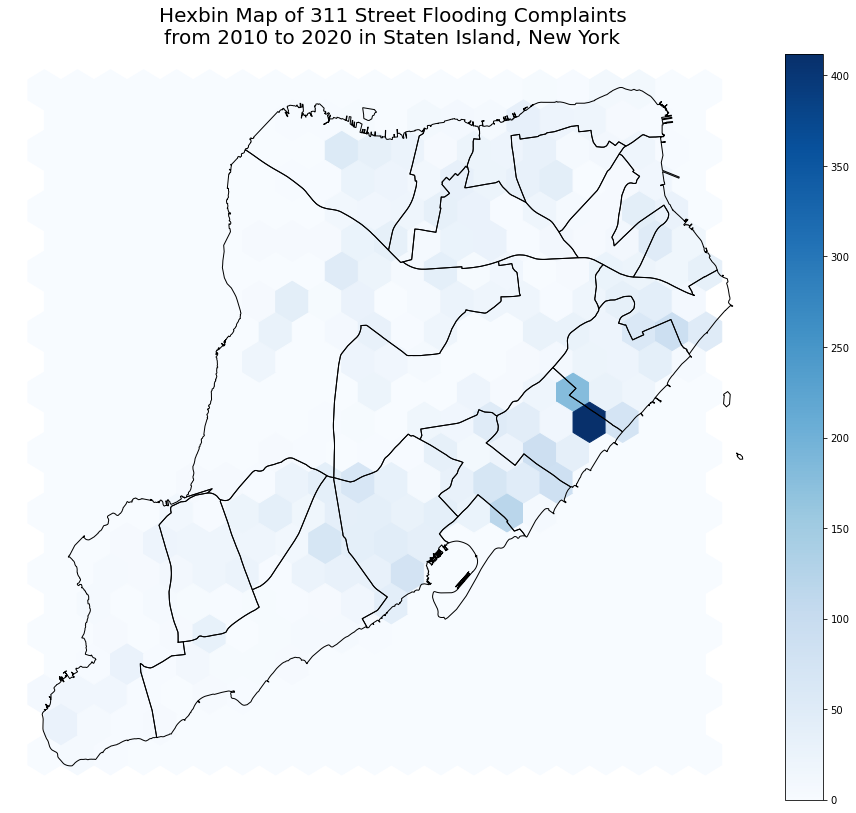

In [278]:
fig, ax = plt.subplots(figsize=(12, 12))

hb = ax.hexbin(flooding_311[flooding_311.borough == 'STATEN ISLAND']['x_coordinate_state_plane'], 
               flooding_311[flooding_311.borough == 'STATEN ISLAND']['y_coordinate_state_plane'], 
               gridsize=20, 
               cmap='Blues')

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
plt.colorbar(hb, cax=cax)

nta_shape[nta_shape.boro_name == 'Staten Island'].to_crs(2263).plot(facecolor="none", 
                                                             edgecolor="black", 
                                                             ax=ax)

ax.set_aspect('equal', 'box')
ax.axis('off')
ax.set_title('Hexbin Map of 311 Street Flooding Complaints\nfrom 2010 to 2020 in Staten Island, New York', 
             fontsize=20, 
             pad=10)
plt.tight_layout()

In [279]:
fig, axs = plt.subplots(2, 3, sharey=False, figsize=(15, 10))


# first plot
hb = axs[0,0].hexbin(flooding_311[flooding_311.borough == 'QUEENS']['x_coordinate_state_plane'], 
               flooding_311[flooding_311.borough == 'QUEENS']['y_coordinate_state_plane'], 
               gridsize=20, 
               cmap='Blues')

divider = make_axes_locatable(axs[0,0])
cax = divider.append_axes("right", size="5%", pad=0.1)
plt.colorbar(hb, cax=cax)

nta_shape[nta_shape.boro_name == 'Queens'].to_crs(2263).plot(facecolor="none", 
                                                             edgecolor="black", 
                                                             ax=axs[0,0])

axs[0,0].set_aspect('equal', 'box')
axs[0,0].axis('off')
axs[0,0].set_title('Queens', fontsize=20)

# second plot
hb = axs[0,1].hexbin(flooding_311[flooding_311.borough == 'BROOKLYN']['x_coordinate_state_plane'], 
               flooding_311[flooding_311.borough == 'BROOKLYN']['y_coordinate_state_plane'], 
               gridsize=20, 
               cmap='Blues')

divider = make_axes_locatable(axs[0,1])
cax = divider.append_axes("right", size="5%", pad=0.1)
plt.colorbar(hb, cax=cax)

nta_shape[nta_shape.boro_name == 'Brooklyn'].to_crs(2263).plot(facecolor="none", 
                                                             edgecolor="black", 
                                                             ax=axs[0,1])

axs[0,1].set_aspect('equal', 'box')
axs[0,1].axis('off')
axs[0,1].set_title('Brooklyn', fontsize=20)

# third plot
hb = axs[0,2].hexbin(flooding_311[flooding_311.borough == 'BRONX']['x_coordinate_state_plane'], 
               flooding_311[flooding_311.borough == 'BRONX']['y_coordinate_state_plane'], 
               gridsize=20, 
               cmap='Blues')

divider = make_axes_locatable(axs[0,2])
cax = divider.append_axes("right", size="5%", pad=0.1)
plt.colorbar(hb, cax=cax)

nta_shape[nta_shape.boro_name == 'Bronx'].to_crs(2263).plot(facecolor="none", 
                                                             edgecolor="black", 
                                                             ax=axs[0,2])

axs[0,2].set_aspect('equal', 'box')
axs[0,2].axis('off')
axs[0,2].set_title('The Bronx', fontsize=20)

# fourth plot
hb = axs[1,0].hexbin(flooding_311[flooding_311.borough == 'MANHATTAN']['x_coordinate_state_plane'], 
               flooding_311[flooding_311.borough == 'MANHATTAN']['y_coordinate_state_plane'], 
               gridsize=20, 
               cmap='Blues')

divider = make_axes_locatable(axs[1,0])
cax = divider.append_axes("right", size="5%", pad=0.1)
plt.colorbar(hb, cax=cax)

nta_shape[nta_shape.boro_name == 'Manhattan'].to_crs(2263).plot(facecolor="none", 
                                                             edgecolor="black", 
                                                             ax=axs[1,0])

axs[1,0].set_aspect('equal', 'box')
axs[1,0].axis('off')
axs[1,0].set_title('Manhattan', fontsize=20)


# fifth plot
hb = axs[1,1].hexbin(flooding_311[flooding_311.borough == 'STATEN ISLAND']['x_coordinate_state_plane'], 
               flooding_311[flooding_311.borough == 'STATEN ISLAND']['y_coordinate_state_plane'], 
               gridsize=20, 
               cmap='Blues')

divider = make_axes_locatable(axs[1,1])
cax = divider.append_axes("right", size="5%", pad=0.1)
plt.colorbar(hb, cax=cax)

nta_shape[nta_shape.boro_name == 'Staten Island'].to_crs(2263).plot(facecolor="none", 
                                                             edgecolor="black", 
                                                             ax=axs[1,1])

axs[1,1].set_aspect('equal', 'box')
axs[1,1].axis('off')
axs[1,1].set_title('Staten Island', fontsize=20)



# sixth plot
hb = axs[1,2].hexbin(flooding_311['x_coordinate_state_plane'], 
               flooding_311['y_coordinate_state_plane'], 
               gridsize=20, 
               cmap='Blues')

divider = make_axes_locatable(axs[1,2])
cax = divider.append_axes("right", size="5%", pad=0.1)
plt.colorbar(hb, cax=cax)

nta_shape.to_crs(2263).plot(facecolor="none", 
                            edgecolor="black", 
                            linewidth=.3,
                            ax=axs[1,2])

axs[1,2].set_aspect('equal', 'box')
axs[1,2].axis('off')
axs[1,2].set_title('All Boroughs', fontsize=20)

# Figure Details
fig.suptitle("Hexbin Map of NYC 311 Street Flooding Complaints by Borough from 2010 to 2020\n", fontsize=20)
plt.tight_layout()
plt.savefig('figures/boroughs.png')

## 5.3 Bar Charts by Neighborhood Tabulation Areas (NTA)

In [280]:
flooding_complaints_with_nta.sort_values(by='count_sq_mi', ascending=False).head(10)

ntacode  shape_area county_fips                               ntaname  \
94     SI45 55429451.22         085                New Dorp-Midland Beach   
130    QN12 61895482.14         081              Hammels-Arverne-Edgemere   
133    QN15 54159776.79         081                Far Rockaway-Bayswater   
0      BK88 54005019.05         047                          Borough Park   
160    QN57 64560809.01         081               Lindenwood-Howard Beach   
176    QN03 43288698.09         081  Springfield Gardens South-Brookville   
70     MN22 10894242.60         061                          East Village   
58     MN17 30191534.33         061                 Midtown-Midtown South   
21     MN21  7526913.95         061                              Gramercy   
57     MN14 15805586.31         061                        Lincoln Square   

     shape_leng      boro_name boro_code  \
94     34336.52  Staten Island         5   
130    83797.48         Queens         4   
133    48674.16         Queens         4   
0      39247.23       Brooklyn         3   
160    79085.71         Queens         4   
176    45322.17         Queens         4   
70     13555.23      Manhattan         1   
58     27032.70      Manhattan         1   
21     12096.89      Manhattan         1   
57     19869.91      Manhattan         1   

                                              geometry  count  count_sq_mi  
94   MULTIPOLYGON (((960721.609 147492.642, 960370....    763       383.75  
130  MULTIPOLYGON (((1048650.082 157173.057, 104869...    696       313.49  
133  MULTIPOLYGON (((1049860.789 154842.320, 104983...    540       277.96  
0    MULTIPOLYGON (((990897.900 169268.121, 990588....    537       277.21  
160  MULTIPOLYGON (((1023868.747 176222.723, 102336...    606       261.68  
176  MULTIPOLYGON (((1051487.928 182175.542, 105150...    398       256.32  
70   MULTIPOLYGON (((989084.531 205727.630, 989108....     94       240.55  
58   MULTIPOLYGON (((991725.244 217725.299, 992169....    248       229.00  
21   MULTIPOLYGON (((990196.892 207745.371, 990187....     61       225.93  
57   MULTIPOLYGON (((991173.649 222552.152, 991046....    123       216.95

In [281]:
flooding_complaints_with_nta['nta_borough'] = flooding_complaints_with_nta['ntaname'] + ' - ' + flooding_complaints_with_nta['boro_name']

In [282]:
plt.figure(figsize=(15,10))

sns.barplot(data=flooding_complaints_with_nta.sort_values(by='count_sq_mi', ascending=False).head(10),
            y='nta_borough',
            x='count_sq_mi',
            color='#1f77b4')

plt.title('Count of NYC 311 Street Flooding Complaints per Square Mile by NTA (2010-2020)', 
          fontsize=15,
          pad=10)
plt.xlabel('Count per Square Mile', fontsize=15)
plt.ylabel('Neighborhood Tabulation Areas (NTA)', fontsize=15)
plt.tight_layout()

In [283]:
plt.figure(figsize=(15,10))

sns.barplot(data=flooding_complaints_with_nta.sort_values(by='count', ascending=False).head(10),
            y='nta_borough',
            x='count',
            color='#1f77b4')

plt.title('Count of NYC 311 Street Flooding Complaints by NTA (2010-2020)', 
          fontsize=15,
          pad=10)
plt.xlabel('Count', fontsize=15)
plt.ylabel('Neighborhood Tabulation Areas (NTA)', fontsize=15)
plt.tight_layout()

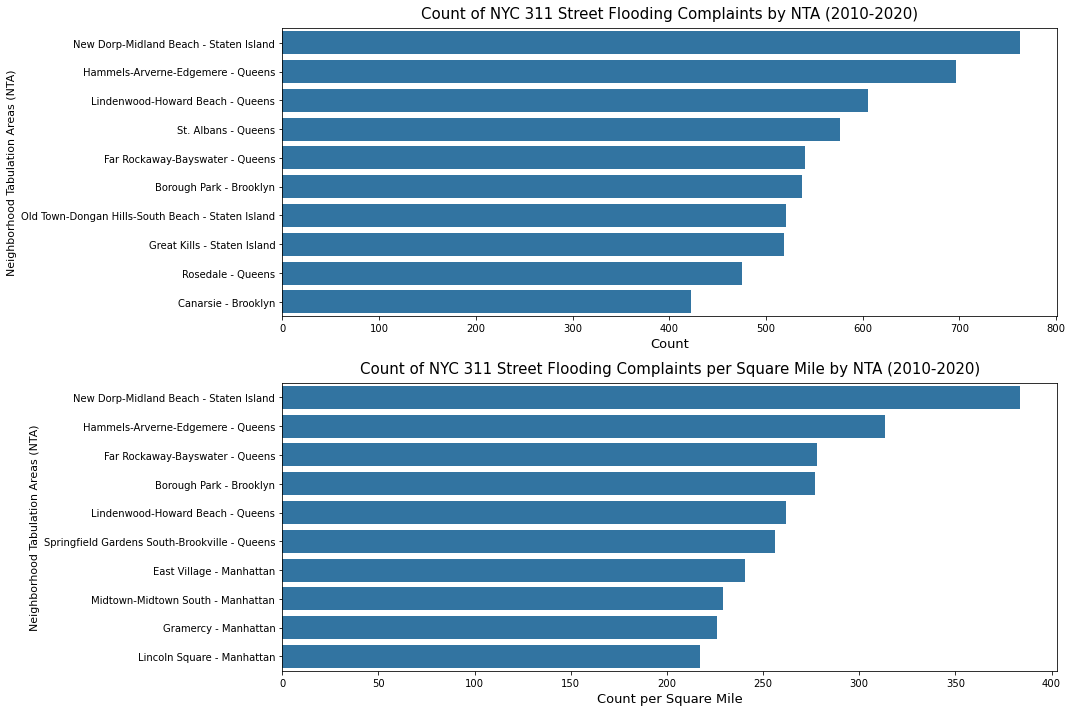

In [284]:
fig, axs = plt.subplots(2, 1, sharey=False, figsize=(15, 10))

# first plot
sns.barplot(data=flooding_complaints_with_nta.sort_values(by='count', ascending=False).head(10),
            y='nta_borough',
            x='count',
            color='#1f77b4',
            ax=axs[0])

axs[0].set_title('Count of NYC 311 Street Flooding Complaints by NTA (2010-2020)', 
          fontsize=15,
          pad=10)
axs[0].set_xlabel('Count', fontsize=13)
axs[0].set_ylabel('Neighborhood Tabulation Areas (NTA)', fontsize=11)

# second plot
sns.barplot(data=flooding_complaints_with_nta.sort_values(by='count_sq_mi', ascending=False).head(10),
            y='nta_borough',
            x='count_sq_mi',
            color='#1f77b4',
            ax=axs[1])

axs[1].set_title('Count of NYC 311 Street Flooding Complaints per Square Mile by NTA (2010-2020)', 
          fontsize=15,
          pad=10)
axs[1].set_xlabel('Count per Square Mile', fontsize=13)
axs[1].set_ylabel('Neighborhood Tabulation Areas (NTA)', fontsize=11)

plt.tight_layout()

# 9. Timedelta of Complaints

In [285]:
flooding_311.head()

unique_key        created_date              closed_date agency  \
0    31862075 2015-10-28 17:44:00  2015-10-29T11:30:00.000    DEP   
1    25163797 2013-03-12 12:38:00  2013-03-12T14:20:00.000    DEP   
2    25185984 2013-03-15 12:13:00  2013-03-18T14:15:00.000    DEP   
3    25187738 2013-03-15 12:20:00  2013-03-15T14:22:00.000    DEP   
4    25338491 2013-04-11 12:16:00  2013-04-11T12:16:00.000    DEP   

                              agency_name complaint_type  \
0  Department of Environmental Protection          Sewer   
1  Department of Environmental Protection          Sewer   
2  Department of Environmental Protection          Sewer   
3  Department of Environmental Protection          Sewer   
4  Department of Environmental Protection          Sewer   

             descriptor  incident_zip intersection_street_1  \
0  Street Flooding (SJ)      11694.00                   NaN   
1  Street Flooding (SJ)      11236.00                   NaN   
2  Street Flooding (SJ)      11236.00                   NaN   
3  Street Flooding (SJ)      11236.00                   NaN   
4  Street Flooding (SJ)      11236.00                   NaN   

  intersection_street_2  ... park_borough latitude longitude  \
0                   NaN  ...       QUEENS    40.58    -73.82   
1                   NaN  ...     BROOKLYN      NaN       NaN   
2                   NaN  ...     BROOKLYN      NaN       NaN   
3                   NaN  ...     BROOKLYN      NaN       NaN   
4                   NaN  ...     BROOKLYN      NaN       NaN   

                                            location  incident_address  \
0  {'latitude': '40.5848189', 'longitude': '-73.8...  BEACH 101 STREET   
1                                                NaN       CHURCH LANE   
2                                                NaN       CHURCH LANE   
3                                                NaN       CHURCH LANE   
4                                                NaN       CHURCH LANE   

        street_name    cross_street_1       cross_street_2  bbl  year  
0  BEACH 101 STREET  ROCKAWAY FREEWAY  BEACH CHANNEL DRIVE  NaN  2015  
1       CHURCH LANE    EAST 89 STREET       EAST 88 STREET  NaN  2013  
2       CHURCH LANE    EAST 89 STREET       EAST 88 STREET  NaN  2013  
3       CHURCH LANE    EAST 89 STREET       EAST 88 STREET  NaN  2013  
4       CHURCH LANE    EAST 89 STREET       EAST 88 STREET  NaN  2013  

[5 rows x 31 columns]

In [286]:
flooding_311.closed_date = pd.to_datetime(flooding_311.closed_date)

flooding_311.head()

unique_key        created_date         closed_date agency  \
0    31862075 2015-10-28 17:44:00 2015-10-29 11:30:00    DEP   
1    25163797 2013-03-12 12:38:00 2013-03-12 14:20:00    DEP   
2    25185984 2013-03-15 12:13:00 2013-03-18 14:15:00    DEP   
3    25187738 2013-03-15 12:20:00 2013-03-15 14:22:00    DEP   
4    25338491 2013-04-11 12:16:00 2013-04-11 12:16:00    DEP   

                              agency_name complaint_type  \
0  Department of Environmental Protection          Sewer   
1  Department of Environmental Protection          Sewer   
2  Department of Environmental Protection          Sewer   
3  Department of Environmental Protection          Sewer   
4  Department of Environmental Protection          Sewer   

             descriptor  incident_zip intersection_street_1  \
0  Street Flooding (SJ)      11694.00                   NaN   
1  Street Flooding (SJ)      11236.00                   NaN   
2  Street Flooding (SJ)      11236.00                   NaN   
3  Street Flooding (SJ)      11236.00                   NaN   
4  Street Flooding (SJ)      11236.00                   NaN   

  intersection_street_2  ... park_borough latitude longitude  \
0                   NaN  ...       QUEENS    40.58    -73.82   
1                   NaN  ...     BROOKLYN      NaN       NaN   
2                   NaN  ...     BROOKLYN      NaN       NaN   
3                   NaN  ...     BROOKLYN      NaN       NaN   
4                   NaN  ...     BROOKLYN      NaN       NaN   

                                            location  incident_address  \
0  {'latitude': '40.5848189', 'longitude': '-73.8...  BEACH 101 STREET   
1                                                NaN       CHURCH LANE   
2                                                NaN       CHURCH LANE   
3                                                NaN       CHURCH LANE   
4                                                NaN       CHURCH LANE   

        street_name    cross_street_1       cross_street_2  bbl  year  
0  BEACH 101 STREET  ROCKAWAY FREEWAY  BEACH CHANNEL DRIVE  NaN  2015  
1       CHURCH LANE    EAST 89 STREET       EAST 88 STREET  NaN  2013  
2       CHURCH LANE    EAST 89 STREET       EAST 88 STREET  NaN  2013  
3       CHURCH LANE    EAST 89 STREET       EAST 88 STREET  NaN  2013  
4       CHURCH LANE    EAST 89 STREET       EAST 88 STREET  NaN  2013  

[5 rows x 31 columns]

In [287]:
flooding_311.iloc[:, :3].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27868 entries, 0 to 27867
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   unique_key    27868 non-null  int64         
 1   created_date  27868 non-null  datetime64[ns]
 2   closed_date   27866 non-null  datetime64[ns]
dtypes: datetime64[ns](2), int64(1)
memory usage: 653.3 KB


In [288]:
flooding_311['complaint_duration'] = flooding_311.closed_date - flooding_311.created_date

flooding_311[['created_date', 'closed_date', 'complaint_duration']].head(10)

created_date         closed_date complaint_duration
0 2015-10-28 17:44:00 2015-10-29 11:30:00    0 days 17:46:00
1 2013-03-12 12:38:00 2013-03-12 14:20:00    0 days 01:42:00
2 2013-03-15 12:13:00 2013-03-18 14:15:00    3 days 02:02:00
3 2013-03-15 12:20:00 2013-03-15 14:22:00    0 days 02:02:00
4 2013-04-11 12:16:00 2013-04-11 12:16:00    0 days 00:00:00
5 2013-04-12 12:07:00 2013-04-12 12:07:00    0 days 00:00:00
6 2013-04-13 08:36:00 2013-04-14 10:30:00    1 days 01:54:00
7 2013-05-08 09:10:00 2013-05-08 09:10:00    0 days 00:00:00
8 2013-05-08 09:15:00 2013-05-08 09:50:00    0 days 00:35:00
9 2013-06-10 22:26:00 2013-06-11 10:30:00    0 days 12:04:00

In [289]:
flooding_311[['created_date', 'closed_date', 'complaint_duration']].tail(10)

created_date         closed_date complaint_duration
27858 2011-12-30 10:00:00 2011-12-31 09:20:00    0 days 23:20:00
27859 2011-12-18 16:47:00 2011-12-19 09:30:00    0 days 16:43:00
27860 2011-12-19 16:39:00 2011-12-23 12:20:00    3 days 19:41:00
27861 2015-06-15 16:37:00 2015-06-15 16:37:00    0 days 00:00:00
27862 2012-04-23 05:18:00 2012-04-23 11:30:00    0 days 06:12:00
27863 2015-07-15 11:54:00 2015-07-15 13:45:00    0 days 01:51:00
27864 2012-05-21 15:13:00 2012-05-25 14:30:00    3 days 23:17:00
27865 2012-05-25 22:41:00 2012-05-29 17:50:00    3 days 19:09:00
27866 2015-07-30 18:05:00 2015-07-30 18:05:00    0 days 00:00:00
27867 2015-09-10 08:45:00 2015-09-10 13:11:00    0 days 04:26:00

In [290]:
flooding_311[['complaint_duration']].describe()

complaint_duration
count                       27866
mean    2 days 14:39:03.389076293
std    13 days 12:17:54.456742438
min            -10 days +16:41:00
25%               0 days 03:02:00
50%               0 days 17:12:00
75%               1 days 18:41:00
max             709 days 10:34:00

In [291]:
flooding_311.sort_values(by='complaint_duration', 
                         ascending=True)[['created_date', 
                                           'closed_date', 
                                           'complaint_duration']].head()

created_date         closed_date complaint_duration
1678  2020-08-12 16:39:00 2020-08-03 09:20:00 -10 days +16:41:00
1113  2020-03-25 10:52:00 2020-03-20 08:45:00  -6 days +21:53:00
25521 2020-06-12 11:39:00 2020-06-10 10:20:00  -3 days +22:41:00
666   2020-07-13 15:18:00 2020-07-12 09:10:00  -2 days +17:52:00
25025 2020-01-17 12:46:00 2020-01-17 12:46:00    0 days 00:00:00

In [292]:
flooding_311.sort_values(by='complaint_duration', 
                         ascending=False)[['created_date', 
                                           'closed_date', 
                                           'complaint_duration']].head()

created_date         closed_date complaint_duration
1123  2017-01-24 08:11:00 2019-01-03 18:45:00  709 days 10:34:00
948   2019-01-20 18:14:00 2020-08-12 11:00:00  569 days 16:46:00
2211  2018-11-16 15:30:00 2020-03-19 11:20:00  488 days 19:50:00
21929 2019-01-11 12:45:00 2020-02-23 13:30:00  408 days 00:45:00
22015 2019-01-28 16:19:00 2020-02-26 09:15:00  393 days 16:56:00

In [293]:
flooding_311['complaint_duration_days'] = flooding_311['complaint_duration'].dt.days
flooding_311['complaint_duration_seconds'] = flooding_311['complaint_duration'].dt.seconds
flooding_311['complaint_duration_hours'] = flooding_311['complaint_duration_days'] * 24 + flooding_311['complaint_duration_seconds'] / 3600

flooding_311.head()

unique_key        created_date         closed_date agency  \
0    31862075 2015-10-28 17:44:00 2015-10-29 11:30:00    DEP   
1    25163797 2013-03-12 12:38:00 2013-03-12 14:20:00    DEP   
2    25185984 2013-03-15 12:13:00 2013-03-18 14:15:00    DEP   
3    25187738 2013-03-15 12:20:00 2013-03-15 14:22:00    DEP   
4    25338491 2013-04-11 12:16:00 2013-04-11 12:16:00    DEP   

                              agency_name complaint_type  \
0  Department of Environmental Protection          Sewer   
1  Department of Environmental Protection          Sewer   
2  Department of Environmental Protection          Sewer   
3  Department of Environmental Protection          Sewer   
4  Department of Environmental Protection          Sewer   

             descriptor  incident_zip intersection_street_1  \
0  Street Flooding (SJ)      11694.00                   NaN   
1  Street Flooding (SJ)      11236.00                   NaN   
2  Street Flooding (SJ)      11236.00                   NaN   
3  Street Flooding (SJ)      11236.00                   NaN   
4  Street Flooding (SJ)      11236.00                   NaN   

  intersection_street_2  ...  incident_address       street_name  \
0                   NaN  ...  BEACH 101 STREET  BEACH 101 STREET   
1                   NaN  ...       CHURCH LANE       CHURCH LANE   
2                   NaN  ...       CHURCH LANE       CHURCH LANE   
3                   NaN  ...       CHURCH LANE       CHURCH LANE   
4                   NaN  ...       CHURCH LANE       CHURCH LANE   

     cross_street_1       cross_street_2 bbl  year complaint_duration  \
0  ROCKAWAY FREEWAY  BEACH CHANNEL DRIVE NaN  2015    0 days 17:46:00   
1    EAST 89 STREET       EAST 88 STREET NaN  2013    0 days 01:42:00   
2    EAST 89 STREET       EAST 88 STREET NaN  2013    3 days 02:02:00   
3    EAST 89 STREET       EAST 88 STREET NaN  2013    0 days 02:02:00   
4    EAST 89 STREET       EAST 88 STREET NaN  2013    0 days 00:00:00   

   complaint_duration_days  complaint_duration_seconds  \
0                     0.00                    63960.00   
1                     0.00                     6120.00   
2                     3.00                     7320.00   
3                     0.00                     7320.00   
4                     0.00                        0.00   

  complaint_duration_hours  
0                    17.77  
1                     1.70  
2                    74.03  
3                     2.03  
4                     0.00  

[5 rows x 35 columns]

In [294]:
flooding_311[['complaint_duration_days', 'complaint_duration_hours']].describe()

complaint_duration_days  complaint_duration_hours
count                 27866.00                  27866.00
mean                      2.20                     62.65
std                      13.49                    324.30
min                     -10.00                   -223.32
25%                       0.00                      3.03
50%                       0.00                     17.20
75%                       1.00                     42.68
max                     709.00                  17026.57

In [295]:
flooding_311.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27868 entries, 0 to 27867
Data columns (total 35 columns):
 #   Column                          Non-Null Count  Dtype          
---  ------                          --------------  -----          
 0   unique_key                      27868 non-null  int64          
 1   created_date                    27868 non-null  datetime64[ns] 
 2   closed_date                     27866 non-null  datetime64[ns] 
 3   agency                          27868 non-null  object         
 4   agency_name                     27868 non-null  object         
 5   complaint_type                  27868 non-null  object         
 6   descriptor                      27868 non-null  object         
 7   incident_zip                    27011 non-null  float64        
 8   intersection_street_1           10090 non-null  object         
 9   intersection_street_2           10090 non-null  object         
 10  address_type                    27862 non-null  object    

In [296]:
gdf = gpd.GeoDataFrame(flooding_311, 
                       geometry=gpd.points_from_xy(flooding_311.x_coordinate_state_plane, 
                                                   flooding_311.y_coordinate_state_plane))

gdf.set_crs(epsg=2263, inplace=True)
gdf.crs

<Projected CRS: EPSG:2263>
Name: NAD83 / New York Long Island (ftUS)
Axis Info [cartesian]:
- X[east]: Easting (US survey foot)
- Y[north]: Northing (US survey foot)
Area of Use:
- name: USA - New York - SPCS - Long Island
- bounds: (-74.26, 40.47, -71.8, 41.3)
Coordinate Operation:
- name: SPCS83 New York Long Island zone (US Survey feet)
- method: Lambert Conic Conformal (2SP)
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [297]:
nta_shape.head()

ntacode     shape_area county_fips        ntaname     shape_leng boro_name  \
0    BK88   54005019.048         047   Borough Park  39247.2278309  Brooklyn   
1    QN51  52488277.5915         081    Murray Hill  33266.9048721    Queens   
2    QN27  19726845.5925         081  East Elmhurst  19816.7121316    Queens   
3    BK95  14522603.5915         047        Erasmus  18756.7018646  Brooklyn   
4    QN07  22887772.8087         081         Hollis  20976.3355996    Queens   

  boro_code                                           geometry  
0         3  MULTIPOLYGON (((990897.900 169268.121, 990588....  
1         4  MULTIPOLYGON (((1038593.459 221913.355, 103936...  
2         4  MULTIPOLYGON (((1022728.275 217530.808, 102305...  
3         3  MULTIPOLYGON (((998608.334 171942.436, 998339....  
4         4  MULTIPOLYGON (((1051539.660 201007.013, 105192...

In [298]:
flooding_complaints_with_nta = gpd.sjoin(gdf, 
                                         nta_shape.to_crs(2263), 
                                         how="inner", 
                                         op='within')

In [299]:
flooding_complaints_with_nta.head()

unique_key        created_date         closed_date agency  \
0      31862075 2015-10-28 17:44:00 2015-10-29 11:30:00    DEP   
352    48315004 2020-12-03 11:59:00 2020-12-04 10:45:00    DEP   
379    48257821 2020-11-26 17:09:00 2020-12-08 15:25:00    DEP   
424    48351959 2020-12-07 09:26:00 2020-12-15 17:30:00    DEP   
698    47194494 2020-08-10 14:49:00 2020-08-11 11:50:00    DEP   

                                agency_name complaint_type  \
0    Department of Environmental Protection          Sewer   
352  Department of Environmental Protection          Sewer   
379  Department of Environmental Protection          Sewer   
424  Department of Environmental Protection          Sewer   
698  Department of Environmental Protection          Sewer   

               descriptor  incident_zip intersection_street_1  \
0    Street Flooding (SJ)      11694.00                   NaN   
352  Street Flooding (SJ)      11694.00                   NaN   
379  Street Flooding (SJ)      11694.00                   NaN   
424  Street Flooding (SJ)      11694.00                   NaN   
698  Street Flooding (SJ)      11694.00                   NaN   

    intersection_street_2  ... complaint_duration_hours  \
0                     NaN  ...                    17.77   
352                   NaN  ...                    22.77   
379                   NaN  ...                   286.27   
424                   NaN  ...                   200.07   
698                   NaN  ...                    21.02   

                           geometry index_right ntacode     shape_area  \
0    POINT (1033547.000 152391.000)         182    QN10  100209724.039   
352  POINT (1021913.000 146937.000)         182    QN10  100209724.039   
379  POINT (1026335.000 149464.000)         182    QN10  100209724.039   
424  POINT (1029969.000 151595.000)         182    QN10  100209724.039   
698  POINT (1026572.000 148945.000)         182    QN10  100209724.039   

    county_fips                                            ntaname  \
0           081  Breezy Point-Belle Harbor-Rockaway Park-Broad ...   
352         081  Breezy Point-Belle Harbor-Rockaway Park-Broad ...   
379         081  Breezy Point-Belle Harbor-Rockaway Park-Broad ...   
424         081  Breezy Point-Belle Harbor-Rockaway Park-Broad ...   
698         081  Breezy Point-Belle Harbor-Rockaway Park-Broad ...   

        shape_leng  boro_name boro_code  
0    119016.703209     Queens         4  
352  119016.703209     Queens         4  
379  119016.703209     Queens         4  
424  119016.703209     Queens         4  
698  119016.703209     Queens         4  

[5 rows x 44 columns]

In [300]:
flooding_complaints_with_nta = flooding_complaints_with_nta.groupby('ntaname').agg({'complaint_duration_hours': 
                                                                                    ['mean', 'median']}).reset_index()

flooding_complaints_with_nta.head()

ntaname complaint_duration_hours       
                                                                  mean median
0                                     Airport                   137.94   3.17
1                     Allerton-Pelham Gardens                    14.23   4.63
2  Annadale-Huguenot-Prince's Bay-Eltingville                    40.44  19.80
3                               Arden Heights                    30.91  20.12
4                                     Astoria                   155.16  16.32

In [301]:
flooding_complaints_with_nta = nta_shape.merge(flooding_complaints_with_nta, 
                                               left_on='ntaname', 
                                               right_on='ntaname')

flooding_complaints_with_nta.head()

/Users/geribauer/anaconda3/lib/python3.7/site-packages/pandas/core/reshape/merge.py:648: UserWarning: merging between different levels can give an unintended result (1 levels on the left,2 on the right)
  warnings.warn(msg, UserWarning)
/Users/geribauer/anaconda3/lib/python3.7/site-packages/pandas/core/generic.py:4152: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


ntacode     shape_area county_fips        ntaname     shape_leng boro_name  \
0    BK88   54005019.048         047   Borough Park  39247.2278309  Brooklyn   
1    QN51  52488277.5915         081    Murray Hill  33266.9048721    Queens   
2    QN27  19726845.5925         081  East Elmhurst  19816.7121316    Queens   
3    BK95  14522603.5915         047        Erasmus  18756.7018646  Brooklyn   
4    QN07  22887772.8087         081         Hollis  20976.3355996    Queens   

  boro_code                                           geometry  \
0         3  MULTIPOLYGON (((990897.900 169268.121, 990588....   
1         4  MULTIPOLYGON (((1038593.459 221913.355, 103936...   
2         4  MULTIPOLYGON (((1022728.275 217530.808, 102305...   
3         3  MULTIPOLYGON (((998608.334 171942.436, 998339....   
4         4  MULTIPOLYGON (((1051539.660 201007.013, 105192...   

   (complaint_duration_hours, mean)  (complaint_duration_hours, median)  
0                             51.77                               18.83  
1                             62.21                               15.07  
2                             72.26                               13.85  
3                             30.73                               20.59  
4                             46.26                               20.13

In [302]:
flooding_complaints_with_nta.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 194 entries, 0 to 193
Data columns (total 10 columns):
 #   Column                              Non-Null Count  Dtype   
---  ------                              --------------  -----   
 0   ntacode                             194 non-null    object  
 1   shape_area                          194 non-null    object  
 2   county_fips                         194 non-null    object  
 3   ntaname                             194 non-null    object  
 4   shape_leng                          194 non-null    object  
 5   boro_name                           194 non-null    object  
 6   boro_code                           194 non-null    object  
 7   geometry                            194 non-null    geometry
 8   (complaint_duration_hours, mean)    194 non-null    float64 
 9   (complaint_duration_hours, median)  194 non-null    float64 
dtypes: float64(2), geometry(1), object(7)
memory usage: 16.7+ KB


In [303]:
flooding_complaints_with_nta.columns

Index([                             'ntacode',
                                 'shape_area',
                                'county_fips',
                                    'ntaname',
                                 'shape_leng',
                                  'boro_name',
                                  'boro_code',
                                   'geometry',
         ('complaint_duration_hours', 'mean'),
       ('complaint_duration_hours', 'median')],
      dtype='object')

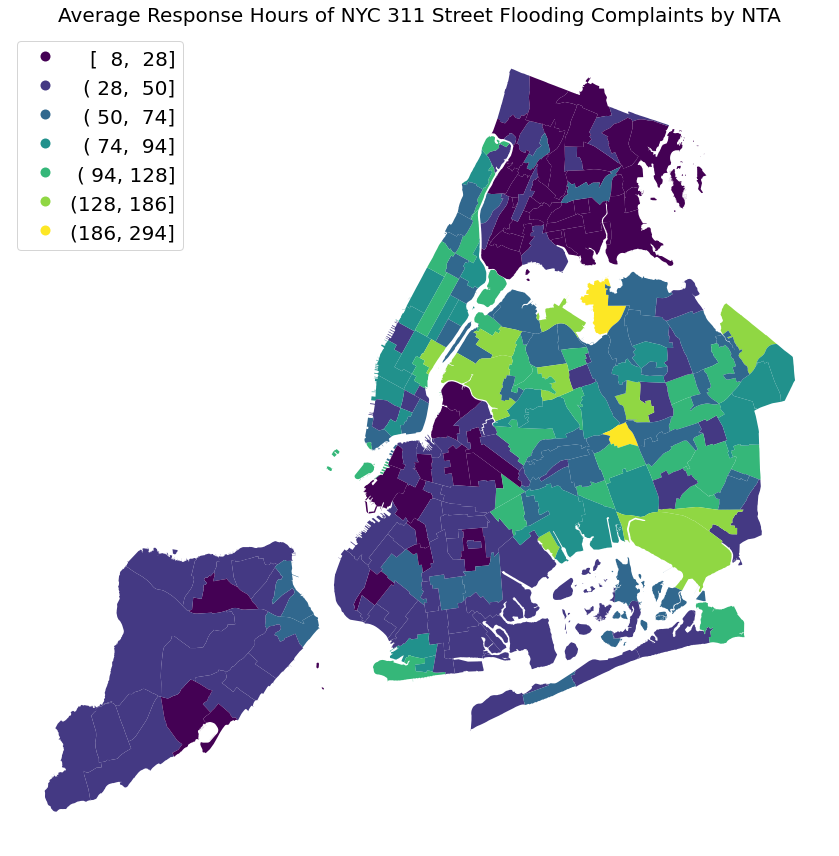

In [304]:
fig, ax = plt.subplots(figsize=(12,12))

flooding_complaints_with_nta.plot(column=('complaint_duration_hours', 'mean'), 
                                  cmap='viridis',
                                  ax=ax, 
                                  legend=True, 
                                  scheme='fisher_jenks',
                                  k=7,
                                  legend_kwds={'loc': "upper left", 
                                              'fmt': "{:,.0f}",
                                              'fontsize': "20"})
leg = ax.get_legend()

hp = leg._legend_box.get_children()[1]
for vp in hp.get_children():
    for row in vp.get_children():
        row.set_width(150)  # need to adapt this manually
        row.mode= "expand"
        row.align="right" 

ax.set_title('Average Response Hours of NYC 311 Street Flooding Complaints by NTA', 
             fontsize=20, 
             pad=10)

ax.set_aspect('equal', 'box')
ax.axis('off')
plt.tight_layout()

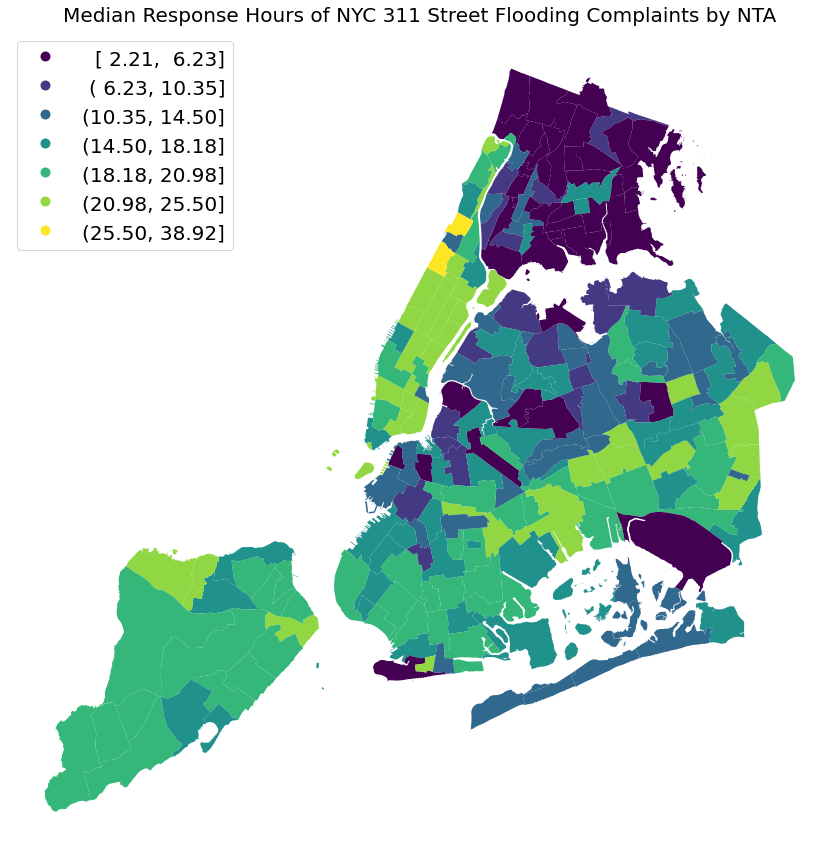

In [305]:
fig, ax = plt.subplots(figsize=(12,12))

flooding_complaints_with_nta.plot(column=('complaint_duration_hours', 'median'), 
                                  cmap='viridis',
                                  ax=ax, 
                                  legend=True, 
                                  scheme='fisher_jenks',
                                  k=7,
                                  legend_kwds={'loc': "upper left", 
                                              'fmt': "{:,.2f}",
                                              'fontsize': "20"})
leg = ax.get_legend()

hp = leg._legend_box.get_children()[1]
for vp in hp.get_children():
    for row in vp.get_children():
        row.set_width(200)  # need to adapt this manually
        row.mode= "expand"
        row.align="right" 

ax.set_title('Median Response Hours of NYC 311 Street Flooding Complaints by NTA', 
             fontsize=20, 
             pad=10)

ax.set_aspect('equal', 'box')
ax.axis('off')
plt.tight_layout()

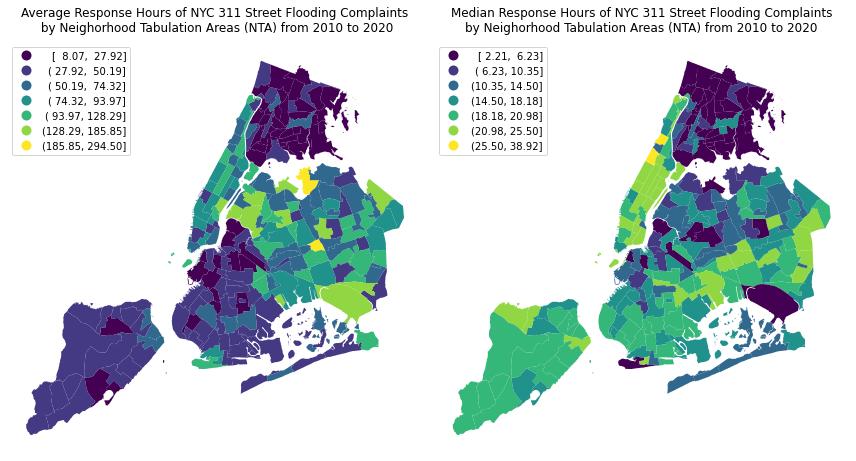

In [306]:
fig, axs = plt.subplots(1, 2, sharey=False, figsize=(12, 12))

flooding_complaints_with_nta.plot(column=('complaint_duration_hours', 'mean'), 
                                  cmap='viridis',
                                  ax=axs[0], 
                                  legend=True, 
                                  scheme='fisher_jenks',
                                  k=7,
                                  legend_kwds={'loc': "upper left", 
                                              'fmt': "{:,.2f}",
                                              'fontsize': "10"})
leg = axs[0].get_legend()

hp = leg._legend_box.get_children()[1]
for vp in hp.get_children():
    for row in vp.get_children():
        row.set_width(110)  # need to adapt this manually
        row.mode= "expand"
        row.align="right" 

axs[0].set_title('Average Response Hours of NYC 311 Street Flooding Complaints\n by Neighorhood Tabulation Areas (NTA) from 2010 to 2020', 
             fontsize=12, 
             pad=10)

axs[0].set_aspect('equal', 'box')
axs[0].axis('off')



flooding_complaints_with_nta.plot(column=('complaint_duration_hours', 'median'), 
                                  cmap='viridis',
                                  ax=axs[1], 
                                  legend=True, 
                                  scheme='fisher_jenks',
                                  k=7,
                                  legend_kwds={'loc': "upper left", 
                                              'fmt': "{:,.2f}",
                                              'fontsize': "10"})
leg = axs[1].get_legend()

hp = leg._legend_box.get_children()[1]
for vp in hp.get_children():
    for row in vp.get_children():
        row.set_width(100)  # need to adapt this manually
        row.mode= "expand"
        row.align="right" 

axs[1].set_title('Median Response Hours of NYC 311 Street Flooding Complaints\nby Neighorhood Tabulation Areas (NTA) from 2010 to 2020', 
             fontsize=12, 
             pad=10)

axs[1].set_aspect('equal', 'box')
axs[1].axis('off')

plt.tight_layout()

In [307]:
flooding_complaints_with_nta.to_csv('data-output/complaints-timedelta-by-nta.csv', index=False)

# 10. Conclusion